# CNN Waste Classification

## Data Pre-Processing

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
#!pip install torch -- uncomment first time you run
import seaborn as sns
#!pip install torch -- uncomment first time you run
import torch
#!pip install torchvision -- uncomment first time you run
import torchvision
from torchvision import datasets, transforms, models
from torch import nn, optim
from sklearn.metrics import confusion_matrix, classification_report
from torchvision.datasets import ImageFolder

In [16]:
# Define set of transformations- convert image to PyTorch tensor, scale pixels from 0-255 to 0.0 - 1.0, normalizes pixels to -1.0 - 1.0
# Output is a (3, 256, 256) array --> Color channels 0.0 - 1.0 and the dimensions 256x256
transform_scratch = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [17]:
# Load in the dataset and apply the transform
from torchvision.datasets import ImageFolder

full_dataset = ImageFolder(root="images/", transform=transform_scratch)
print(f"Total images: {len(full_dataset)}") # Print number of images
print(f"Class labels: {full_dataset.classes}") # Print all of the class labels

Total images: 15000
Class labels: ['aerosol_cans', 'aluminum_food_cans', 'aluminum_soda_cans', 'cardboard_boxes', 'cardboard_packaging', 'clothing', 'coffee_grounds', 'disposable_plastic_cutlery', 'eggshells', 'food_waste', 'glass_beverage_bottles', 'glass_cosmetic_containers', 'glass_food_jars', 'magazines', 'newspaper', 'office_paper', 'paper_cups', 'plastic_cup_lids', 'plastic_detergent_bottles', 'plastic_food_containers', 'plastic_shopping_bags', 'plastic_soda_bottles', 'plastic_straws', 'plastic_trash_bags', 'plastic_water_bottles', 'shoes', 'steel_food_cans', 'styrofoam_cups', 'styrofoam_food_containers', 'tea_bags']


## Define Data Splits

-- **NOTES** --

Here we can mess around with different training splits such as 
- Random split
- Evenly divide each sub-category (Stratified)
- Evenly divide each sub-category AND default/real world images (Double Stratified)
- Train more on default images, test more on real world (Studio Train)

All of these are implemented below. Maybe we start with either random or double stratified but can test out all going forward.

In [18]:
from torch.utils.data import random_split
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

import numpy as np

# Set the split sizes
dataset_size = len(full_dataset)
train_size = int(0.7 * dataset_size) # TRAIN proportion = 0.7
val_size = int(0.15 * dataset_size) # VALIDATION proportion = 0.15
test_size = dataset_size - train_size - val_size  # TEST proportion = 0.15

##### RANDOMLY split the dataset #####
random_train_dataset, random_val_dataset, random_test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

print(f"Random Train size: {len(random_train_dataset)}")
print(f"Random Validation size: {len(random_val_dataset)}")
print(f"Random Test size: {len(random_test_dataset)}\n")

##### STRATIFIED SPLIT (Evenly distribute each category between the train, val, test proportions) #####
## Get all targets from the dataset
targets = np.array(full_dataset.targets)

# 1st split: Separate 70% training data and 30% temp (which will become val + test)
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, temp_idx = next(splitter.split(np.zeros(len(targets)), targets))

# Use class labels from the temp split to do a second stratified split (val and test)
temp_targets = targets[temp_idx]

# 2nd split: Split the 30% temp into 15% val and 15% test
splitter2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx, test_idx = next(splitter2.split(np.zeros(len(temp_idx)), temp_targets))

# Since val/test indices refer to the temp set, map them back to the full dataset
val_idx = temp_idx[val_idx]
test_idx = temp_idx[test_idx]

# Create PyTorch Subset objects for each split, using the final indices
strat_train_dataset = Subset(full_dataset, train_idx)
strat_val_dataset = Subset(full_dataset, val_idx)
strat_test_dataset = Subset(full_dataset, test_idx)

# Print sizes again
print(f"Stratified Train size: {len(strat_train_dataset)}")
print(f"Stratified Validation size: {len(strat_val_dataset)}")
print(f"Stratified Test size: {len(strat_test_dataset)}\n")

##### DOUBLE STRATIFIED SPLIT (Evenly distribute each category and real world vs default between train/val/test) #####
# Step 1: Create a list of full file paths for all images
all_paths = [full_dataset.samples[i][0] for i in range(len(full_dataset))]

# Step 2: Create a combined stratification label for each image: e.g., "plastic_water_bottles__default"
combined_labels = []
for path in all_paths:
    # Example path: images/plastic_water_bottles/default/image1.png
    parts = path.split(os.sep)
    category = parts[-3]  # e.g., plastic_water_bottles
    subtype = parts[-2]   # e.g., default or real_world
    combined_label = f"{category}__{subtype}"
    combined_labels.append(combined_label)

combined_labels = np.array(combined_labels)

# Step 3: First split: 70% train, 30% temp (val + test)
split1 = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, temp_idx = next(split1.split(np.zeros(len(combined_labels)), combined_labels))

# Step 4: Second split: split temp into 50% val, 50% test (i.e., 15% each overall)
temp_labels = combined_labels[temp_idx]
split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx_rel, test_idx_rel = next(split2.split(np.zeros(len(temp_labels)), temp_labels))

# Map relative val/test indices back to full dataset indices
val_idx = temp_idx[val_idx_rel]
test_idx = temp_idx[test_idx_rel]

# Step 5: Create PyTorch Subsets
double_strat_train_dataset = Subset(full_dataset, train_idx)
double_strat_val_dataset = Subset(full_dataset, val_idx)
double_strat_test_dataset = Subset(full_dataset, test_idx)

# Optional sanity check
print(f"Double Stratified Train size: {len(double_strat_train_dataset)}")
print(f"Double Stratified Validation size: {len(double_strat_val_dataset)}")
print(f"Double Stratified Test size: {len(double_strat_test_dataset)}\n")

##### DEFAULT v REAL WORLD TRAIN SPLIT (All default goes to train, real_world fills in remaining train, then val & test) #####
# Map: class index → class name (e.g., 0 → 'plastic_water_bottles')
# Map class index → class name (e.g., 0 → 'plastic_water_bottles')
idx_to_class = {v: k for k, v in full_dataset.class_to_idx.items()}

# Split default and real_world
default_indices = []
realworld_indices = []

for i, (path, class_idx) in enumerate(full_dataset.samples):
    subtype = path.split(os.sep)[-2]  # 'default' or 'real_world'
    if subtype == "default":
        default_indices.append(i)
    elif subtype == "real_world":
        realworld_indices.append(i)

# Calculate dataset sizes
total_size = len(full_dataset)
target_train_size = int(0.7 * total_size)
target_val_size = int(0.15 * total_size)
target_test_size = total_size - target_train_size - target_val_size

# Use all default images in training set
train_idx = set(default_indices)

# How many more real_world images needed for train?
remaining_needed = target_train_size - len(train_idx)

# Sanity check
if remaining_needed < 0:
    raise ValueError("Too many default images to satisfy 70% train split!")

# Convert to array
realworld_indices = np.array(realworld_indices)

# First: get required real_world images for training
rw_train_idx, rw_temp_idx = train_test_split(
    realworld_indices,
    train_size=remaining_needed,
    random_state=42,
    shuffle=True
)

# Second: split the rest equally into val and test
rw_val_idx, rw_test_idx = train_test_split(
    rw_temp_idx,
    test_size=0.5,
    random_state=42,
    shuffle=True
)

# Final index sets
train_idx.update(rw_train_idx)
val_idx = set(rw_val_idx)
test_idx = set(rw_test_idx)

# Create subsets
drw_train_dataset = Subset(full_dataset, sorted(train_idx))
drw_val_dataset = Subset(full_dataset, sorted(val_idx))
drw_test_dataset = Subset(full_dataset, sorted(test_idx))

# Print final sizes
print(f"DRW Train size: {len(drw_train_dataset)}")
print(f"DRW Validation size: {len(drw_val_dataset)}")
print(f"DRW Test size: {len(drw_test_dataset)}")

Random Train size: 10500
Random Validation size: 2250
Random Test size: 2250

Stratified Train size: 10500
Stratified Validation size: 2250
Stratified Test size: 2250

Double Stratified Train size: 10500
Double Stratified Validation size: 2250
Double Stratified Test size: 2250

DRW Train size: 10500
DRW Validation size: 2250
DRW Test size: 2250


### Implement Data Loader

In [19]:
from torch.utils.data import DataLoader

# Use data loader to improve efficiency of loading data during training
batch_size = 32  # Can be adjusted

# shuffle = True : Ensures all images from a category aren't trained on consecutively
random_train_loader = DataLoader(random_train_dataset, batch_size=batch_size, shuffle=True) 
random_val_loader = DataLoader(random_val_dataset, batch_size=batch_size, shuffle=False)
random_test_loader = DataLoader(random_test_dataset, batch_size=batch_size, shuffle=False)


double_strat_train_loader = DataLoader(double_strat_train_dataset, batch_size=batch_size, shuffle=True) 
double_strat_train_loader = DataLoader(double_strat_val_dataset, batch_size=batch_size, shuffle=False)
double_strat_train_loader = DataLoader(double_strat_test_dataset, batch_size=batch_size, shuffle=False)


# Normalize Augmentations, Augmentation Threshold, Soften Augmentations (Going off MAIN model 5)

Using device: cpu

Epoch 1/10


→ Train Loss: 3.0522 | Val Loss: 2.5355

Epoch 2/10


→ Train Loss: 2.2584 | Val Loss: 2.0247

Epoch 3/10


→ Train Loss: 1.5284 | Val Loss: 1.6891

Epoch 4/10


→ Train Loss: 0.9251 | Val Loss: 1.6978

Epoch 5/10


→ Train Loss: 0.5701 | Val Loss: 1.7629

Epoch 6/10


→ Train Loss: 1.8361 | Val Loss: 1.4700

Epoch 7/10


→ Train Loss: 1.4619 | Val Loss: 1.4658

Epoch 8/10


→ Train Loss: 1.2862 | Val Loss: 1.4180

Epoch 9/10


→ Train Loss: 1.1246 | Val Loss: 1.4887

Epoch 10/10


→ Train Loss: 1.0095 | Val Loss: 1.5172


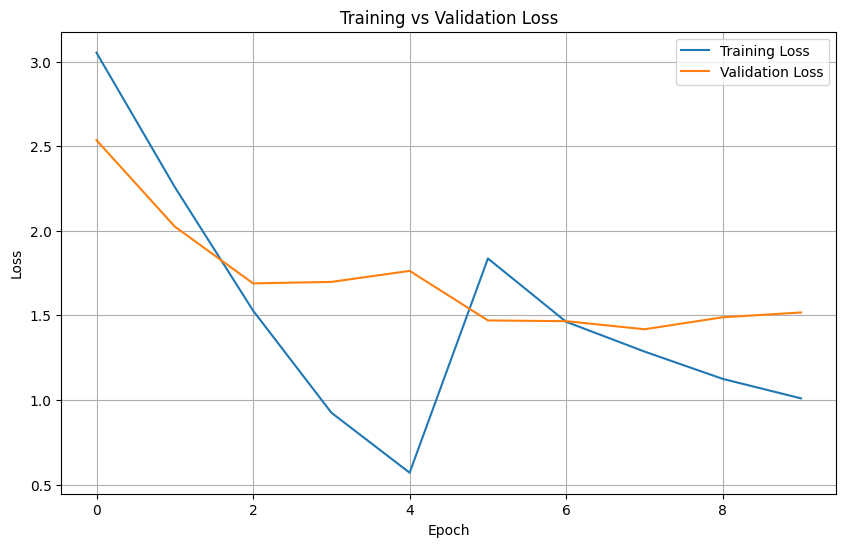

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

# ----------------------
# DEVICE SETUP
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------
# TRANSFORMS
# ----------------------
transform_augmented = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

transform_plain = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# ----------------------
# DATASET LOADING
# ----------------------
base_train_dataset = ImageFolder("images/", transform=transform_plain)
val_dataset = ImageFolder("images/", transform=transform_plain)

# Replace with your actual splits from earlier
# Example:
# random_train_dataset and random_val_dataset should have .indices attributes

train_indices = random_train_dataset.indices
val_indices = random_val_dataset.indices

# ----------------------
# MODEL DEFINITION (with adjusted Dropout)
# ----------------------
class WasteClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super(WasteClassifierCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.flattened_size = 128 * 32 * 32
        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.dropout = nn.Dropout(p=0.3)  # Slightly less dropout to retain learning
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# ----------------------
# INITIALIZATION
# ----------------------
num_classes = len(base_train_dataset.classes)
model = WasteClassifierCNN(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# ----------------------
# TRAINING LOOP
# ----------------------
num_epochs = 10
patience = 3
best_val_loss = float('inf')
patience_counter = 0
history = {"loss": [], "val_loss": []}

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Switch transforms after epoch 5
    base_train_dataset.transform = transform_augmented if epoch >= 5 else transform_plain

    train_loader = DataLoader(Subset(base_train_dataset, train_indices), batch_size=32, shuffle=True)
    val_loader = DataLoader(Subset(val_dataset, val_indices), batch_size=32, shuffle=False)

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    loop = tqdm(train_loader, total=len(train_loader), leave=False)

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_postfix({
            "acc": f"{(correct / total):.4f}",
            "loss": f"{running_loss / (loop.n + 1):.4f}"
        })

    train_loss = running_loss / len(train_loader)
    history["loss"].append(train_loss)

    # ----------------------
    # VALIDATION
    # ----------------------
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    history["val_loss"].append(val_loss)

    print(f"→ Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # ----------------------
    # EARLY STOPPING
    # ----------------------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

# ----------------------
# PLOT LOSS CURVES
# ----------------------
plt.figure(figsize=(10, 6))
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


<Figure size 1400x1400 with 0 Axes>

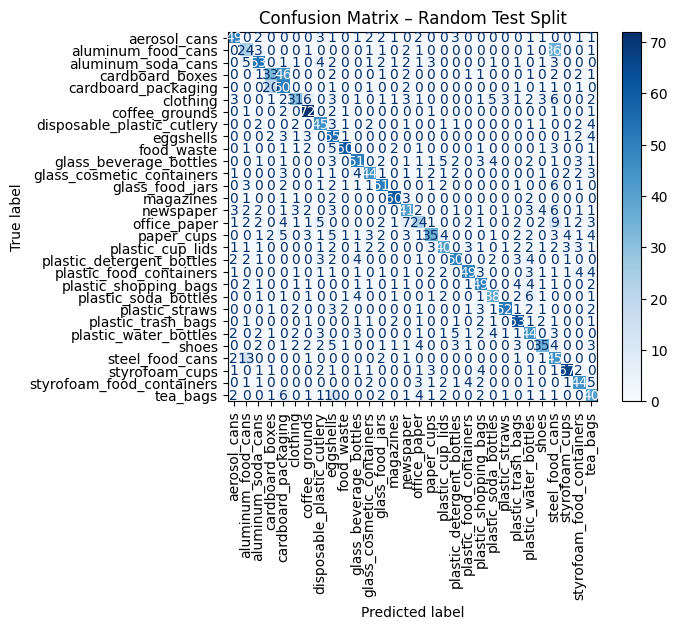


🔍 Per-Class Accuracy Breakdown:
----------------------------------------
aerosol_cans                   — Accuracy: 70.00%
aluminum_food_cans             — Accuracy: 33.80%
aluminum_soda_cans             — Accuracy: 64.63%
cardboard_boxes                — Accuracy: 35.48%
cardboard_packaging            — Accuracy: 64.10%
clothing                       — Accuracy: 40.79%
coffee_grounds                 — Accuracy: 88.89%
disposable_plastic_cutlery     — Accuracy: 68.18%
eggshells                      — Accuracy: 76.39%
food_waste                     — Accuracy: 75.95%
glass_beverage_bottles         — Accuracy: 62.20%
glass_cosmetic_containers      — Accuracy: 62.86%
glass_food_jars                — Accuracy: 69.86%
magazines                      — Accuracy: 85.71%
newspaper                      — Accuracy: 53.25%
office_paper                   — Accuracy: 32.88%
paper_cups                     — Accuracy: 41.67%
plastic_cup_lids               — Accuracy: 54.79%
plastic_detergent_bottles 

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

# ----------------------
# SET UP TEST LOADER
# ----------------------
# Use unaugmented val_dataset and the correct random test split
test_loader = DataLoader(
    torch.utils.data.Subset(val_dataset, random_test_dataset.indices),
    batch_size=32,
    shuffle=False
)

# ----------------------
# ACCURACY COUNTERS
# ----------------------
class_correct = [0] * num_classes
class_total = [0] * num_classes
default_correct = 0
default_total = 0
real_correct = 0
real_total = 0

# Get corresponding image paths for the test indices
test_paths = [val_dataset.samples[i][0] for i in random_test_dataset.indices]

# ----------------------
# EVALUATION LOOP
# ----------------------
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        for j in range(len(labels)):
            true_label = labels[j].item()
            pred_label = predicted[j].item()
            class_total[true_label] += 1
            if true_label == pred_label:
                class_correct[true_label] += 1

            # Check path type: default or real_world
            img_index = i * test_loader.batch_size + j
            path = test_paths[img_index]
            if "default" in path:
                default_total += 1
                if true_label == pred_label:
                    default_correct += 1
            elif "real_world" in path:
                real_total += 1
                if true_label == pred_label:
                    real_correct += 1

            all_preds.append(pred_label)
            all_labels.append(true_label)

# ----------------------
# CONFUSION MATRIX
# ----------------------
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_dataset.classes)

plt.figure(figsize=(14, 14))
disp.plot(xticks_rotation=90, cmap="Blues")
plt.title("Confusion Matrix – Random Test Split")
plt.show()

# ----------------------
# PER-CLASS ACCURACY
# ----------------------
print("\n🔍 Per-Class Accuracy Breakdown:\n" + "-" * 40)
for i, class_name in enumerate(val_dataset.classes):
    acc = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0.0
    print(f"{class_name:30s} — Accuracy: {acc:.2f}%")

# ----------------------
# DEFAULT vs REAL-WORLD ACCURACY
# ----------------------
default_acc = 100 * default_correct / default_total if default_total > 0 else 0.0
real_acc = 100 * real_correct / real_total if real_total > 0 else 0.0

print("\n📸 Accuracy by Photo Type:\n" + "-" * 40)
print(f"Default Photos      — Accuracy: {default_acc:.2f}% ({default_correct}/{default_total})")
print(f"Real-World Photos   — Accuracy: {real_acc:.2f}% ({real_correct}/{real_total})")

# ----------------------
# OVERALL ACCURACY
# ----------------------
correct = sum(class_correct)
total = sum(class_total)
overall_acc = 100 * correct / total
print(f"\n✅ Overall Test Accuracy: {overall_acc:.2f}%")


# RE-RUNNING MODEL 8 FROM MAIN (EFFICIENT NET)

/Users/lukestockbridge/miniconda3/envs/nn/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/lukestockbridge/miniconda3/envs/nn/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cpu


Epoch 1 | Train Loss: 1.8949 | Val Loss: 1.0616


Epoch 2 | Train Loss: 1.2642 | Val Loss: 0.8914


Epoch 3 | Train Loss: 1.1274 | Val Loss: 0.8415


Epoch 4 | Train Loss: 1.0742 | Val Loss: 0.7823


Epoch 5 | Train Loss: 1.0140 | Val Loss: 0.7700


Epoch 6 | Train Loss: 0.9913 | Val Loss: 0.7285


Epoch 7 | Train Loss: 0.9325 | Val Loss: 0.7135


Epoch 8 | Train Loss: 0.9161 | Val Loss: 0.6970


Epoch 9 | Train Loss: 0.9164 | Val Loss: 0.6710


Epoch 10 | Train Loss: 0.8845 | Val Loss: 0.6887


Epoch 11 | Train Loss: 0.8676 | Val Loss: 0.6652


Epoch 12 | Train Loss: 0.8611 | Val Loss: 0.6557


Epoch 13 | Train Loss: 0.8504 | Val Loss: 0.6480


Epoch 14 | Train Loss: 0.8298 | Val Loss: 0.6566


Epoch 15 | Train Loss: 0.8418 | Val Loss: 0.6749


Epoch 16 | Train Loss: 0.8174 | Val Loss: 0.6479


Epoch 17 | Train Loss: 0.8109 | Val Loss: 0.6559


Epoch 18 | Train Loss: 0.7909 | Val Loss: 0.6448


Epoch 19 | Train Loss: 0.8056 | Val Loss: 0.6299


Epoch 20 | Train Loss: 0.7816 | Val Loss: 0.6418


Epoch 21 | Train Loss: 0.7815 | Val Loss: 0.6260


Epoch 22 | Train Loss: 0.7710 | Val Loss: 0.6089


Epoch 23 | Train Loss: 0.7557 | Val Loss: 0.6281


Epoch 24 | Train Loss: 0.7611 | Val Loss: 0.6200


Epoch 25 | Train Loss: 0.7811 | Val Loss: 0.6240
Early stopping triggered after 25 epochs.


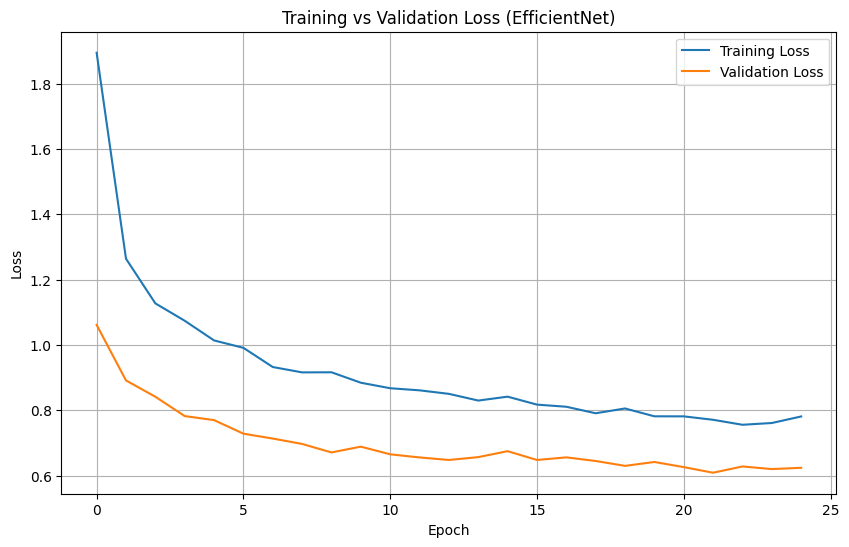

In [7]:
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ----------------------
# DEVICE SETUP
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------
# TRANSFORMS (224x224 for EfficientNet)
# ----------------------
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# ----------------------
# DATASETS + LOADERS
# ----------------------
full_dataset_train = ImageFolder("images/", transform=transform_train)
full_dataset_val = ImageFolder("images/", transform=transform_val)

train_loader = DataLoader(torch.utils.data.Subset(full_dataset_train, double_strat_train_dataset.indices), batch_size=32, shuffle=True)
val_loader = DataLoader(torch.utils.data.Subset(full_dataset_val, double_strat_val_dataset.indices), batch_size=32, shuffle=False)
test_loader = DataLoader(torch.utils.data.Subset(full_dataset_val, double_strat_test_dataset.indices), batch_size=32, shuffle=False)
test_paths = [full_dataset_val.samples[i][0] for i in double_strat_test_dataset.indices]

# ----------------------
# MODEL SETUP (EfficientNet-B0)
# ----------------------
num_classes = len(full_dataset_train.classes)
model = models.efficientnet_b0(pretrained=True)

# Freeze base layers
for param in model.parameters():
    param.requires_grad = False

# Replace classifier head
model.classifier[1] = nn.Sequential(
    nn.Linear(model.classifier[1].in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)
)

model = model.to(device)

# ----------------------
# LOSS & OPTIMIZER
# ----------------------
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier[1].parameters(), lr=0.001, weight_decay=1e-4)

# ----------------------
# TRAINING LOOP
# ----------------------
num_epochs = 25
patience = 3
best_val_loss = float('inf')
patience_counter = 0
history = {"loss": [], "val_loss": []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, total=len(train_loader), leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_postfix({
            "acc": f"{(correct / total):.4f}",
            "loss": f"{running_loss / (loop.n + 1):.4f}"
        })

    train_loss = running_loss / len(train_loader)
    history["loss"].append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    history["val_loss"].append(val_loss)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_efficientnet_model.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

# ----------------------
# PLOT LOSS
# ----------------------
plt.figure(figsize=(10, 6))
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (EfficientNet)")
plt.legend()
plt.grid(True)
plt.show()

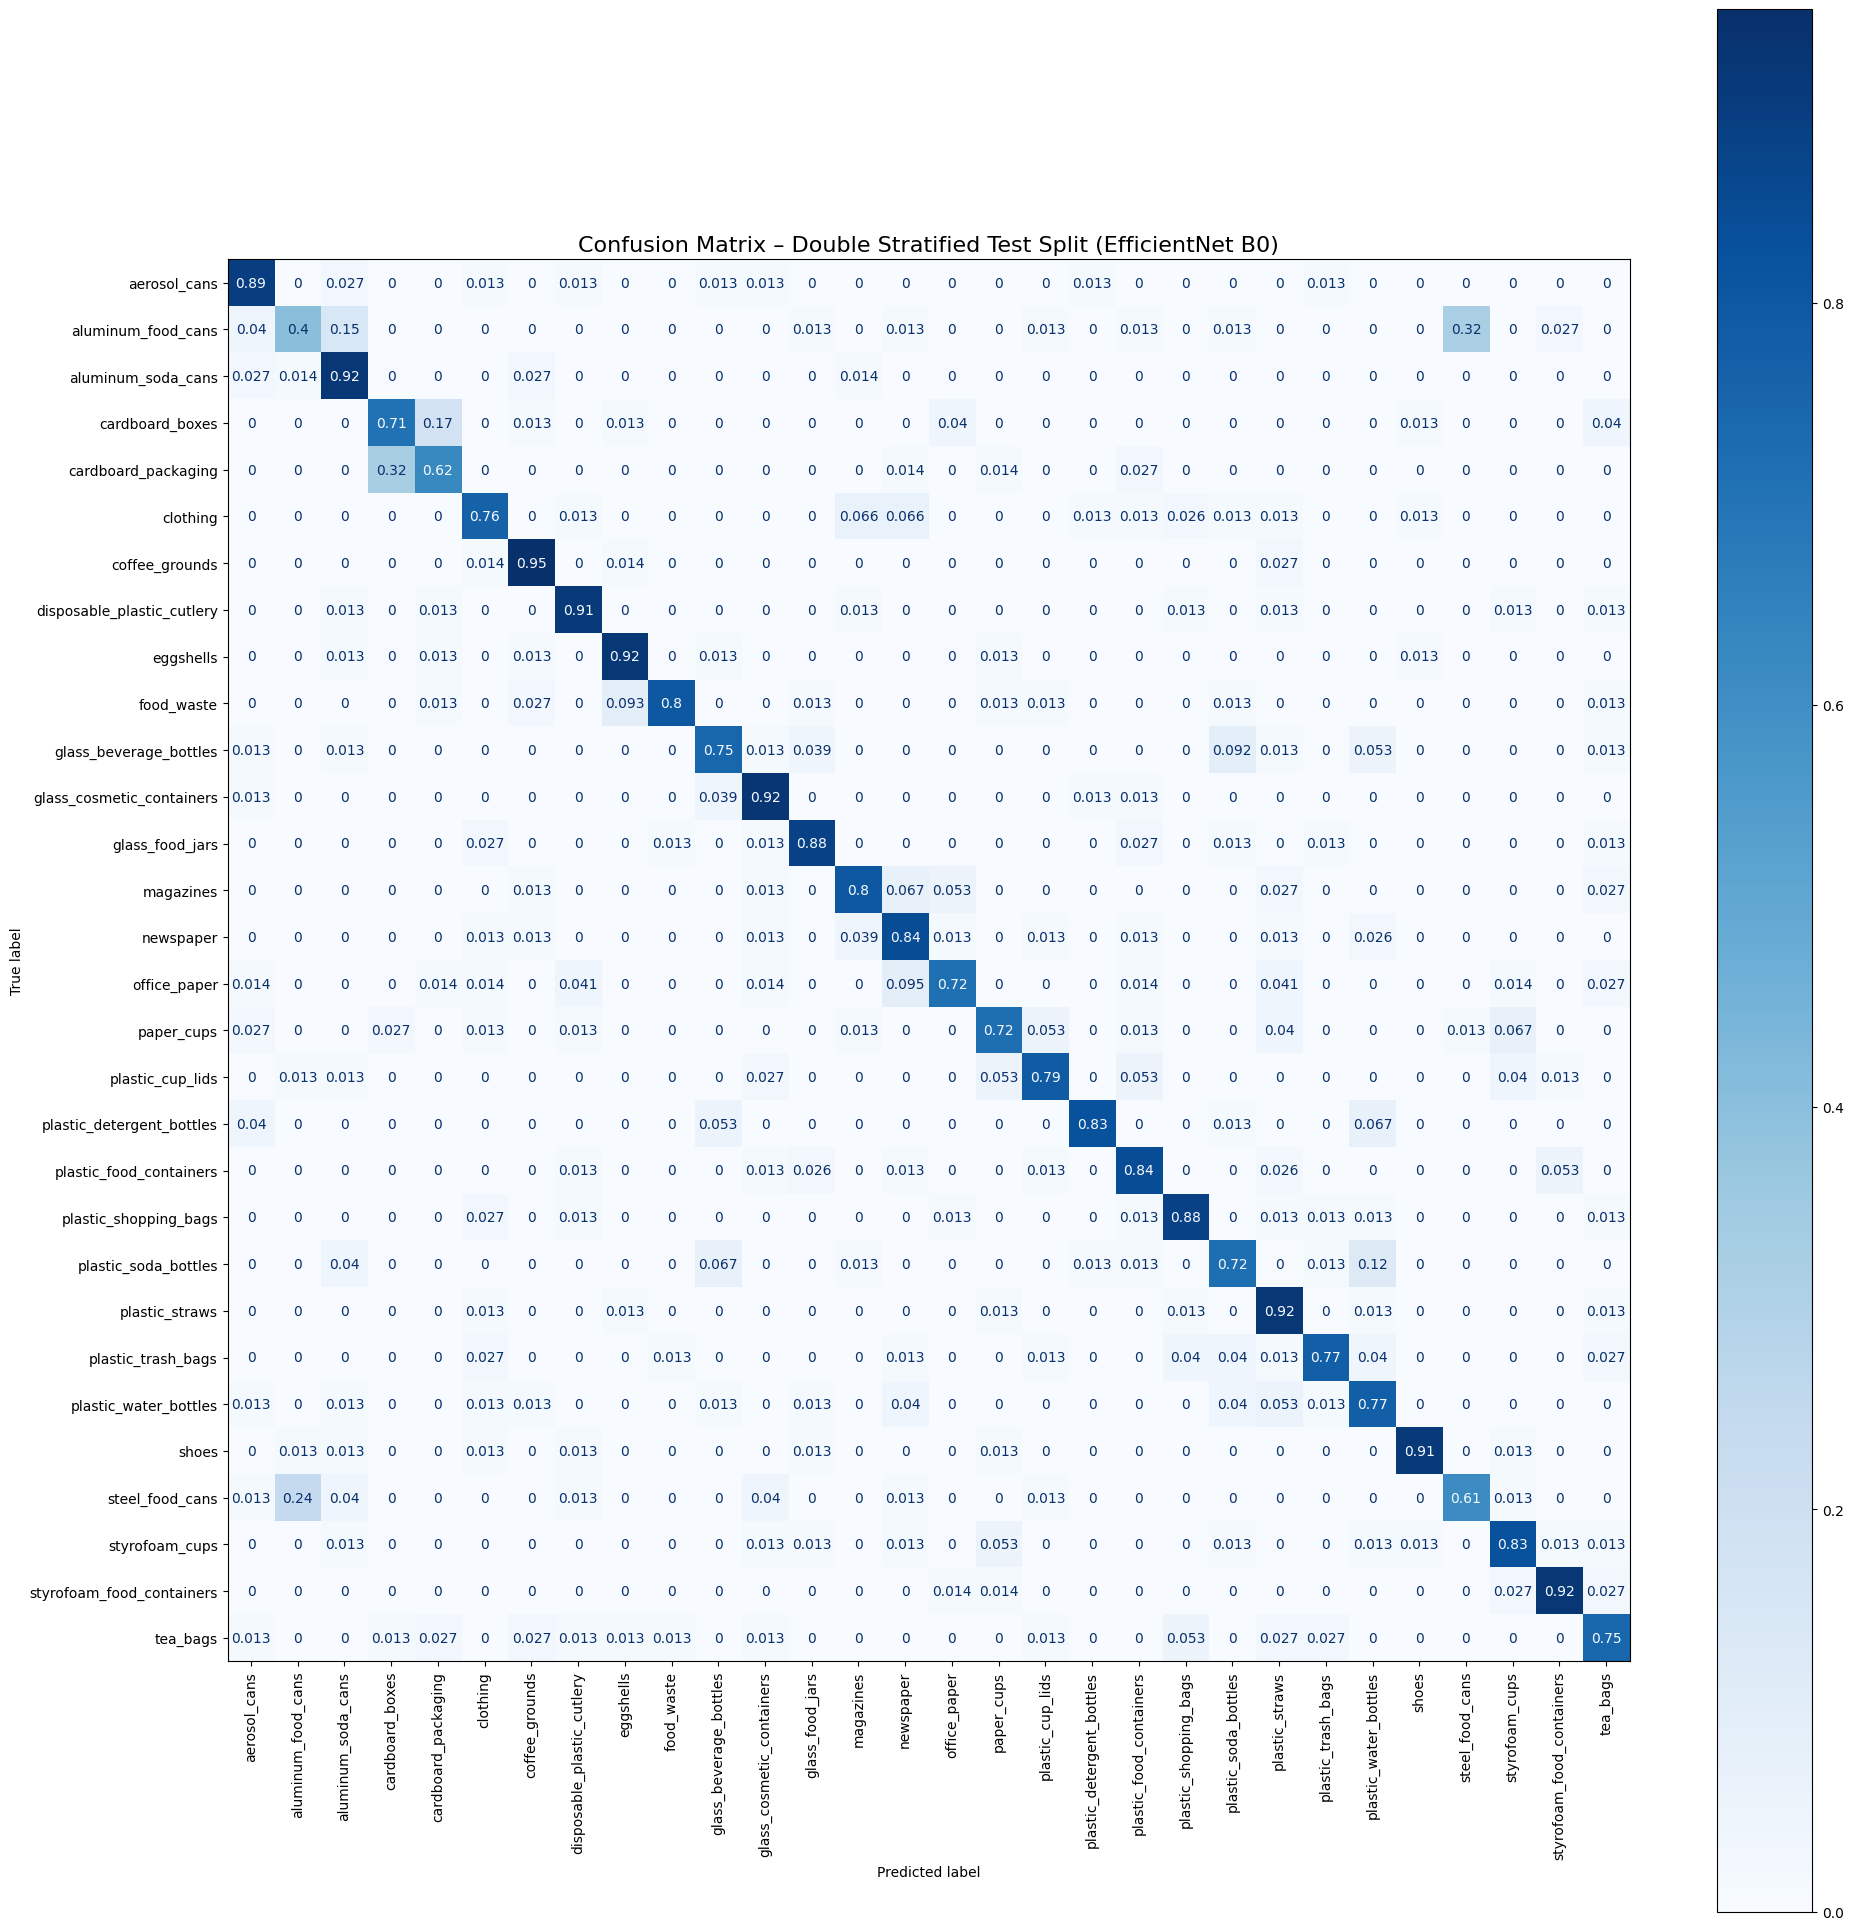


🔍 Per-Class Accuracy Breakdown:
----------------------------------------
aerosol_cans                   — Accuracy: 89.33%
aluminum_food_cans             — Accuracy: 40.00%
aluminum_soda_cans             — Accuracy: 91.89%
cardboard_boxes                — Accuracy: 70.67%
cardboard_packaging            — Accuracy: 62.16%
clothing                       — Accuracy: 76.32%
coffee_grounds                 — Accuracy: 94.59%
disposable_plastic_cutlery     — Accuracy: 90.67%
eggshells                      — Accuracy: 92.00%
food_waste                     — Accuracy: 80.00%
glass_beverage_bottles         — Accuracy: 75.00%
glass_cosmetic_containers      — Accuracy: 92.11%
glass_food_jars                — Accuracy: 88.00%
magazines                      — Accuracy: 80.00%
newspaper                      — Accuracy: 84.21%
office_paper                   — Accuracy: 71.62%
paper_cups                     — Accuracy: 72.00%
plastic_cup_lids               — Accuracy: 78.67%
plastic_detergent_bottles 

In [8]:
# Re-initialize the model architecture
model = models.efficientnet_b0(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

model.classifier[1] = nn.Sequential(
    nn.Linear(model.classifier[1].in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)
)
model = model.to(device)

# Load saved best weights
model.load_state_dict(torch.load("best_efficientnet_model.pt"))
model.eval()


# ----------------------
# ACCURACY & BREAKDOWNS (EfficientNet B0)
# ----------------------
b0_class_correct = [0] * num_classes
b0_class_total = [0] * num_classes
b0_default_correct = 0
b0_default_total = 0
b0_real_correct = 0
b0_real_total = 0
b0_all_preds = []
b0_all_labels = []

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        for j in range(len(labels)):
            true_label = labels[j]
            pred_label = predicted[j]
            b0_class_total[true_label] += 1
            if true_label == pred_label:
                b0_class_correct[true_label] += 1

            path = test_paths[i * test_loader.batch_size + j]
            if "default" in path:
                b0_default_total += 1
                if true_label == pred_label:
                    b0_default_correct += 1
            elif "real_world" in path:
                b0_real_total += 1
                if true_label == pred_label:
                    b0_real_correct += 1

            b0_all_preds.append(pred_label.cpu())
            b0_all_labels.append(true_label.cpu())

# ----------------------
# CONFUSION MATRIX (Normalized)
# ----------------------
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

b0_cm = confusion_matrix(b0_all_labels, b0_all_preds, normalize="true")
b0_disp = ConfusionMatrixDisplay(confusion_matrix=b0_cm, display_labels=full_dataset_val.classes)

fig, ax = plt.subplots(figsize=(20, 20))
b0_disp.plot(ax=ax, xticks_rotation=90, cmap="Blues", colorbar=True)

# Improve font size and layout
ax.set_xticklabels(full_dataset_val.classes, fontsize=10, rotation=90)
ax.set_yticklabels(full_dataset_val.classes, fontsize=10)
plt.title("Confusion Matrix – Double Stratified Test Split (EfficientNet B0)", fontsize=16)
plt.tight_layout()
plt.show()

# ----------------------
# PER-CLASS ACCURACY
# ----------------------
print("\n🔍 Per-Class Accuracy Breakdown:\n" + "-" * 40)
for i, class_name in enumerate(full_dataset_val.classes):
    acc = 100 * b0_class_correct[i] / b0_class_total[i] if b0_class_total[i] > 0 else 0.0
    print(f"{class_name:30s} — Accuracy: {acc:.2f}%")

# ----------------------
# TYPE-BASED ACCURACY
# ----------------------
b0_default_acc = 100 * b0_default_correct / b0_default_total if b0_default_total > 0 else 0.0
b0_real_acc = 100 * b0_real_correct / b0_real_total if b0_real_total > 0 else 0.0

print("\n📸 Accuracy by Photo Type:\n" + "-" * 40)
print(f"Default Photos      — Accuracy: {b0_default_acc:.2f}% ({b0_default_correct}/{b0_default_total})")
print(f"Real-World Photos   — Accuracy: {b0_real_acc:.2f}% ({b0_real_correct}/{b0_real_total})")

# ----------------------
# OVERALL ACCURACY (TEST SET)
# ----------------------
b0_overall_acc = 100 * sum(b0_class_correct) / sum(b0_class_total)
print(f"\n✅ Overall Test Accuracy (Double Stratified - EfficientNet B0): {b0_overall_acc:.2f}%")


# USED TO REPRESENT CPH RECYCLING CATEGORIES

In [22]:
subcategory_to_main_category = {
    # Plastic, Food and Beverage Cartons (Plast, mad- og drikkekartoner)
    "disposable_plastic_cutlery": "Plastic",
    "plastic_cup_lids": "Plastic",
    "plastic_detergent_bottles": "Plastic",
    "plastic_food_containers": "Plastic",
    "plastic_shopping_bags": "Plastic",
    "plastic_soda_bottles": "Plastic",
    "plastic_straws": "Plastic",
    "plastic_trash_bags": "Plastic",
    "plastic_water_bottles": "Plastic",
    "styrofoam_cups": "Plastic",
    "styrofoam_food_containers": "Plastic",

    # Metal
    "aerosol_cans": "Metal",
    "aluminum_food_cans": "Metal",
    "aluminum_soda_cans": "Metal",
    "steel_food_cans": "Metal",

    # Glass (Glas)
    "glass_beverage_bottles": "Glass",
    "glass_cosmetic_containers": "Glass",
    "glass_food_jars": "Glass",

    # Cardboard (Pap)
    "cardboard_boxes": "Cardboard",
    "cardboard_packaging": "Cardboard",

    # Paper (Papir)
    "magazines": "Paper",
    "newspaper": "Paper",
    "office_paper": "Paper",

    # Food Waste (Madaffald)
    "coffee_grounds": "Food Waste",
    "eggshells": "Food Waste",
    "food_waste": "Food Waste",
    "tea_bags": "Food Waste",

    # Textile Waste (Tekstilaffald)
    "shoes": "Textile Waste",
    "clothing": "Textile Waste",

    # Residual Waste (Restaffald)
    "paper_cups": "Residual Waste"
}


# ADJUSTED CATEGORY ACCURACY


🎯 Adjusted Accuracy (Grouped by Main Categories): 89.73%


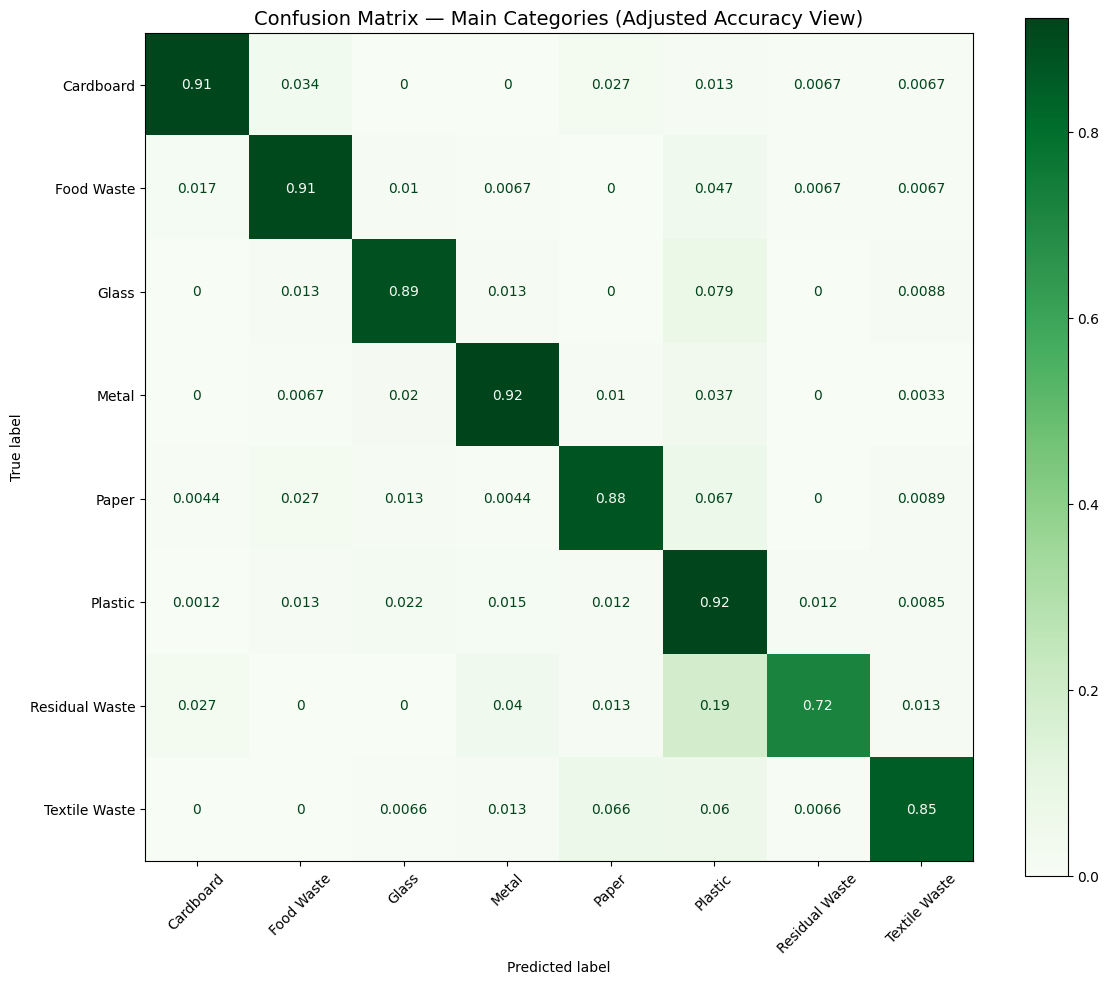

In [10]:
# First, map class indices to class names
idx_to_class = {i: name for i, name in enumerate(full_dataset_val.classes)}

# Now create the main category mapping for indices
idx_to_main_category = {
    i: subcategory_to_main_category[name]
    for i, name in idx_to_class.items()
}

# Track adjusted stats
b0_adj_class_correct = [0] * num_classes
b0_adj_correct = 0
b0_adj_total = 0

# Collect true/pred labels by main category for confusion matrix
b0_all_preds_main = []
b0_all_labels_main = []

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        for j in range(len(labels)):
            true_label = labels[j].item()
            pred_label = predicted[j].item()

            b0_class_total[true_label] += 1
            if true_label == pred_label:
                b0_class_correct[true_label] += 1

            # Adjusted accuracy
            true_main = idx_to_main_category[true_label]
            pred_main = idx_to_main_category[pred_label]
            if true_main == pred_main:
                b0_adj_correct += 1
                b0_adj_class_correct[true_label] += 1

            b0_adj_total += 1

            # Track label/category for confusion matrix
            b0_all_preds.append(pred_label)
            b0_all_labels.append(true_label)
            b0_all_preds_main.append(pred_main)
            b0_all_labels_main.append(true_main)

# ----------------------
# Adjusted Accuracy Summary
# ----------------------
b0_adj_accuracy = 100 * b0_adj_correct / b0_adj_total
print(f"\n🎯 Adjusted Accuracy (Grouped by Main Categories): {b0_adj_accuracy:.2f}%")

# ----------------------
# Confusion Matrix — Main Categories
# ----------------------
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

# Unique main category labels
main_categories = sorted(set(b0_all_labels_main + b0_all_preds_main))

main_cm = confusion_matrix(b0_all_labels_main, b0_all_preds_main, labels=main_categories, normalize='true')
main_disp = ConfusionMatrixDisplay(confusion_matrix=main_cm, display_labels=main_categories)

fig, ax = plt.subplots(figsize=(12, 10))
main_disp.plot(ax=ax, cmap="Greens", xticks_rotation=45)
plt.title("Confusion Matrix — Main Categories (Adjusted Accuracy View)", fontsize=14)
plt.tight_layout()
plt.show()


# MODEL 8.5 (IMPROVED EFFICIENT NET) - DEEPER HEAD, IMPROVED LR, UNFREEZE DEEP LAYERS, AUGMENTATION ADJUSTMENTS

Using device: cpu


Epoch 1 | Train Loss: 3.4117 | Val Loss: 3.2782


Epoch 2 | Train Loss: 3.2856 | Val Loss: 3.1261


Epoch 3 | Train Loss: 3.1422 | Val Loss: 2.9442


Epoch 4 | Train Loss: 2.9743 | Val Loss: 2.7145


Epoch 5 | Train Loss: 2.7835 | Val Loss: 2.4777


Epoch 6 | Train Loss: 2.5860 | Val Loss: 2.2608


Epoch 7 | Train Loss: 2.3891 | Val Loss: 2.0618


Epoch 8 | Train Loss: 2.2173 | Val Loss: 1.8722


Epoch 9 | Train Loss: 2.0537 | Val Loss: 1.7360


Epoch 10 | Train Loss: 1.9090 | Val Loss: 1.5818


Epoch 11 | Train Loss: 1.7758 | Val Loss: 1.4688


Epoch 12 | Train Loss: 1.6594 | Val Loss: 1.3472


Epoch 13 | Train Loss: 1.5468 | Val Loss: 1.2334


Epoch 14 | Train Loss: 1.4314 | Val Loss: 1.1542


Epoch 15 | Train Loss: 1.3712 | Val Loss: 1.0658


Epoch 16 | Train Loss: 1.2888 | Val Loss: 0.9942


Epoch 17 | Train Loss: 1.2116 | Val Loss: 0.9465


Epoch 18 | Train Loss: 1.1579 | Val Loss: 0.8901


Epoch 19 | Train Loss: 1.0992 | Val Loss: 0.8596


Epoch 20 | Train Loss: 1.0599 | Val Loss: 0.8072


Epoch 21 | Train Loss: 1.0302 | Val Loss: 0.7718


Epoch 22 | Train Loss: 0.9801 | Val Loss: 0.7529


Epoch 23 | Train Loss: 0.9382 | Val Loss: 0.7217


Epoch 24 | Train Loss: 0.9218 | Val Loss: 0.7010


Epoch 25 | Train Loss: 0.8797 | Val Loss: 0.6686


Epoch 26 | Train Loss: 0.8589 | Val Loss: 0.6554


Epoch 27 | Train Loss: 0.8328 | Val Loss: 0.6541


Epoch 28 | Train Loss: 0.8018 | Val Loss: 0.6175


Epoch 29 | Train Loss: 0.7882 | Val Loss: 0.6148


Epoch 30 | Train Loss: 0.7579 | Val Loss: 0.5919


Epoch 31 | Train Loss: 0.7310 | Val Loss: 0.5906


Epoch 32 | Train Loss: 0.7290 | Val Loss: 0.5659


Epoch 33 | Train Loss: 0.7146 | Val Loss: 0.5689


Epoch 34 | Train Loss: 0.6877 | Val Loss: 0.5480


Epoch 35 | Train Loss: 0.6724 | Val Loss: 0.5390


Epoch 36 | Train Loss: 0.6668 | Val Loss: 0.5440


Epoch 37 | Train Loss: 0.6436 | Val Loss: 0.5305


Epoch 38 | Train Loss: 0.6459 | Val Loss: 0.5176


Epoch 39 | Train Loss: 0.6210 | Val Loss: 0.5138


Epoch 40 | Train Loss: 0.6172 | Val Loss: 0.4999


Epoch 41 | Train Loss: 0.6047 | Val Loss: 0.5087


Epoch 42 | Train Loss: 0.5918 | Val Loss: 0.4963


Epoch 43 | Train Loss: 0.5784 | Val Loss: 0.4967


Epoch 44 | Train Loss: 0.5667 | Val Loss: 0.4867


Epoch 45 | Train Loss: 0.5510 | Val Loss: 0.4889


Epoch 46 | Train Loss: 0.5438 | Val Loss: 0.4772


Epoch 47 | Train Loss: 0.5379 | Val Loss: 0.4788


Epoch 48 | Train Loss: 0.5079 | Val Loss: 0.4763


Epoch 49 | Train Loss: 0.5181 | Val Loss: 0.4650


Epoch 50 | Train Loss: 0.5095 | Val Loss: 0.4654


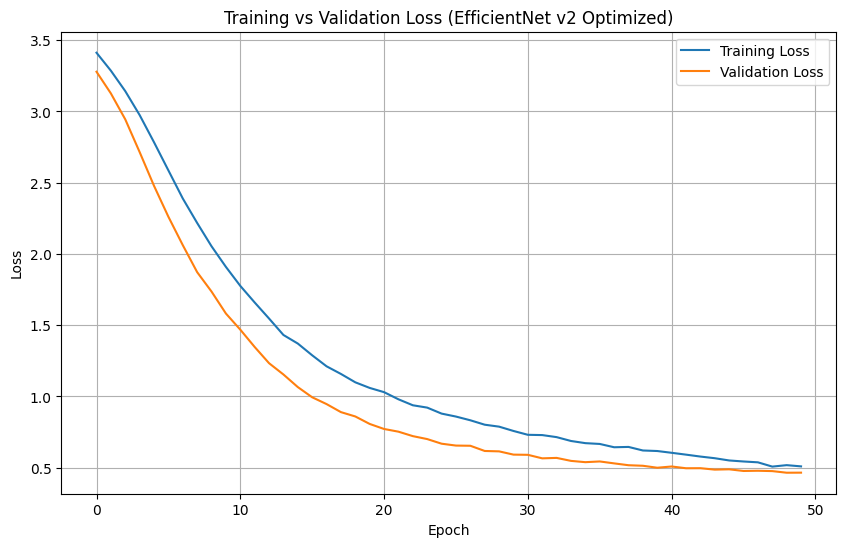

In [14]:
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.optim.lr_scheduler import ReduceLROnPlateau

# ----------------------
# DEVICE SETUP
# ----------------------
torch.backends.cudnn.benchmark = True  # ✅ Speed up training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------
# TRANSFORMS (Optimized)
# ----------------------
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomApply([transforms.ColorJitter(0.2, 0.2, 0.2, 0.1)], p=0.5),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05)),  # 🔄 Simplified affine
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ----------------------
# DATASETS + LOADERS
# ----------------------
full_dataset_train = ImageFolder("images/", transform=transform_train)
full_dataset_val = ImageFolder("images/", transform=transform_val)

train_loader = DataLoader(torch.utils.data.Subset(full_dataset_train, double_strat_train_dataset.indices), batch_size=32, shuffle=True)
val_loader = DataLoader(torch.utils.data.Subset(full_dataset_val, double_strat_val_dataset.indices), batch_size=32, shuffle=False)
test_loader = DataLoader(torch.utils.data.Subset(full_dataset_val, double_strat_test_dataset.indices), batch_size=32, shuffle=False)
test_paths = [full_dataset_val.samples[i][0] for i in double_strat_test_dataset.indices]

# ----------------------
# MODEL SETUP (EfficientNet-B0)
# ----------------------
num_classes = len(full_dataset_train.classes)
model = models.efficientnet_b0(pretrained=True)

# ✅ Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# ✅ Fine-tune later layers only
for name, param in model.named_parameters():
    if "features.6" in name or "features.7" in name or "classifier" in name:
        param.requires_grad = True

# ✅ Deeper classifier head
model.classifier[1] = nn.Sequential(
    nn.Linear(model.classifier[1].in_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, num_classes)
)

model = model.to(device)

# ----------------------
# LOSS, OPTIMIZER, SCHEDULER
# ----------------------
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# ----------------------
# TRAINING LOOP
# ----------------------
num_epochs = 50 
patience = 5
best_val_loss = float('inf')
patience_counter = 0
history = {"loss": [], "val_loss": []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, total=len(train_loader), leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_postfix({
            "acc": f"{(correct / total):.4f}",
            "loss": f"{running_loss / (loop.n + 1):.4f}"
        })

    train_loss = running_loss / len(train_loader)
    history["loss"].append(train_loss)

    # ----------------------
    # VALIDATION
    # ----------------------
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()

    val_loss /= len(val_loader)
    history["val_loss"].append(val_loss)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # ----------------------
    # EARLY STOPPING
    # ----------------------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_efficientnet_model_v2.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

# ----------------------
# PLOT LOSS CURVES
# ----------------------
plt.figure(figsize=(10, 6))
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (EfficientNet v2 Optimized)")
plt.legend()
plt.grid(True)
plt.show()


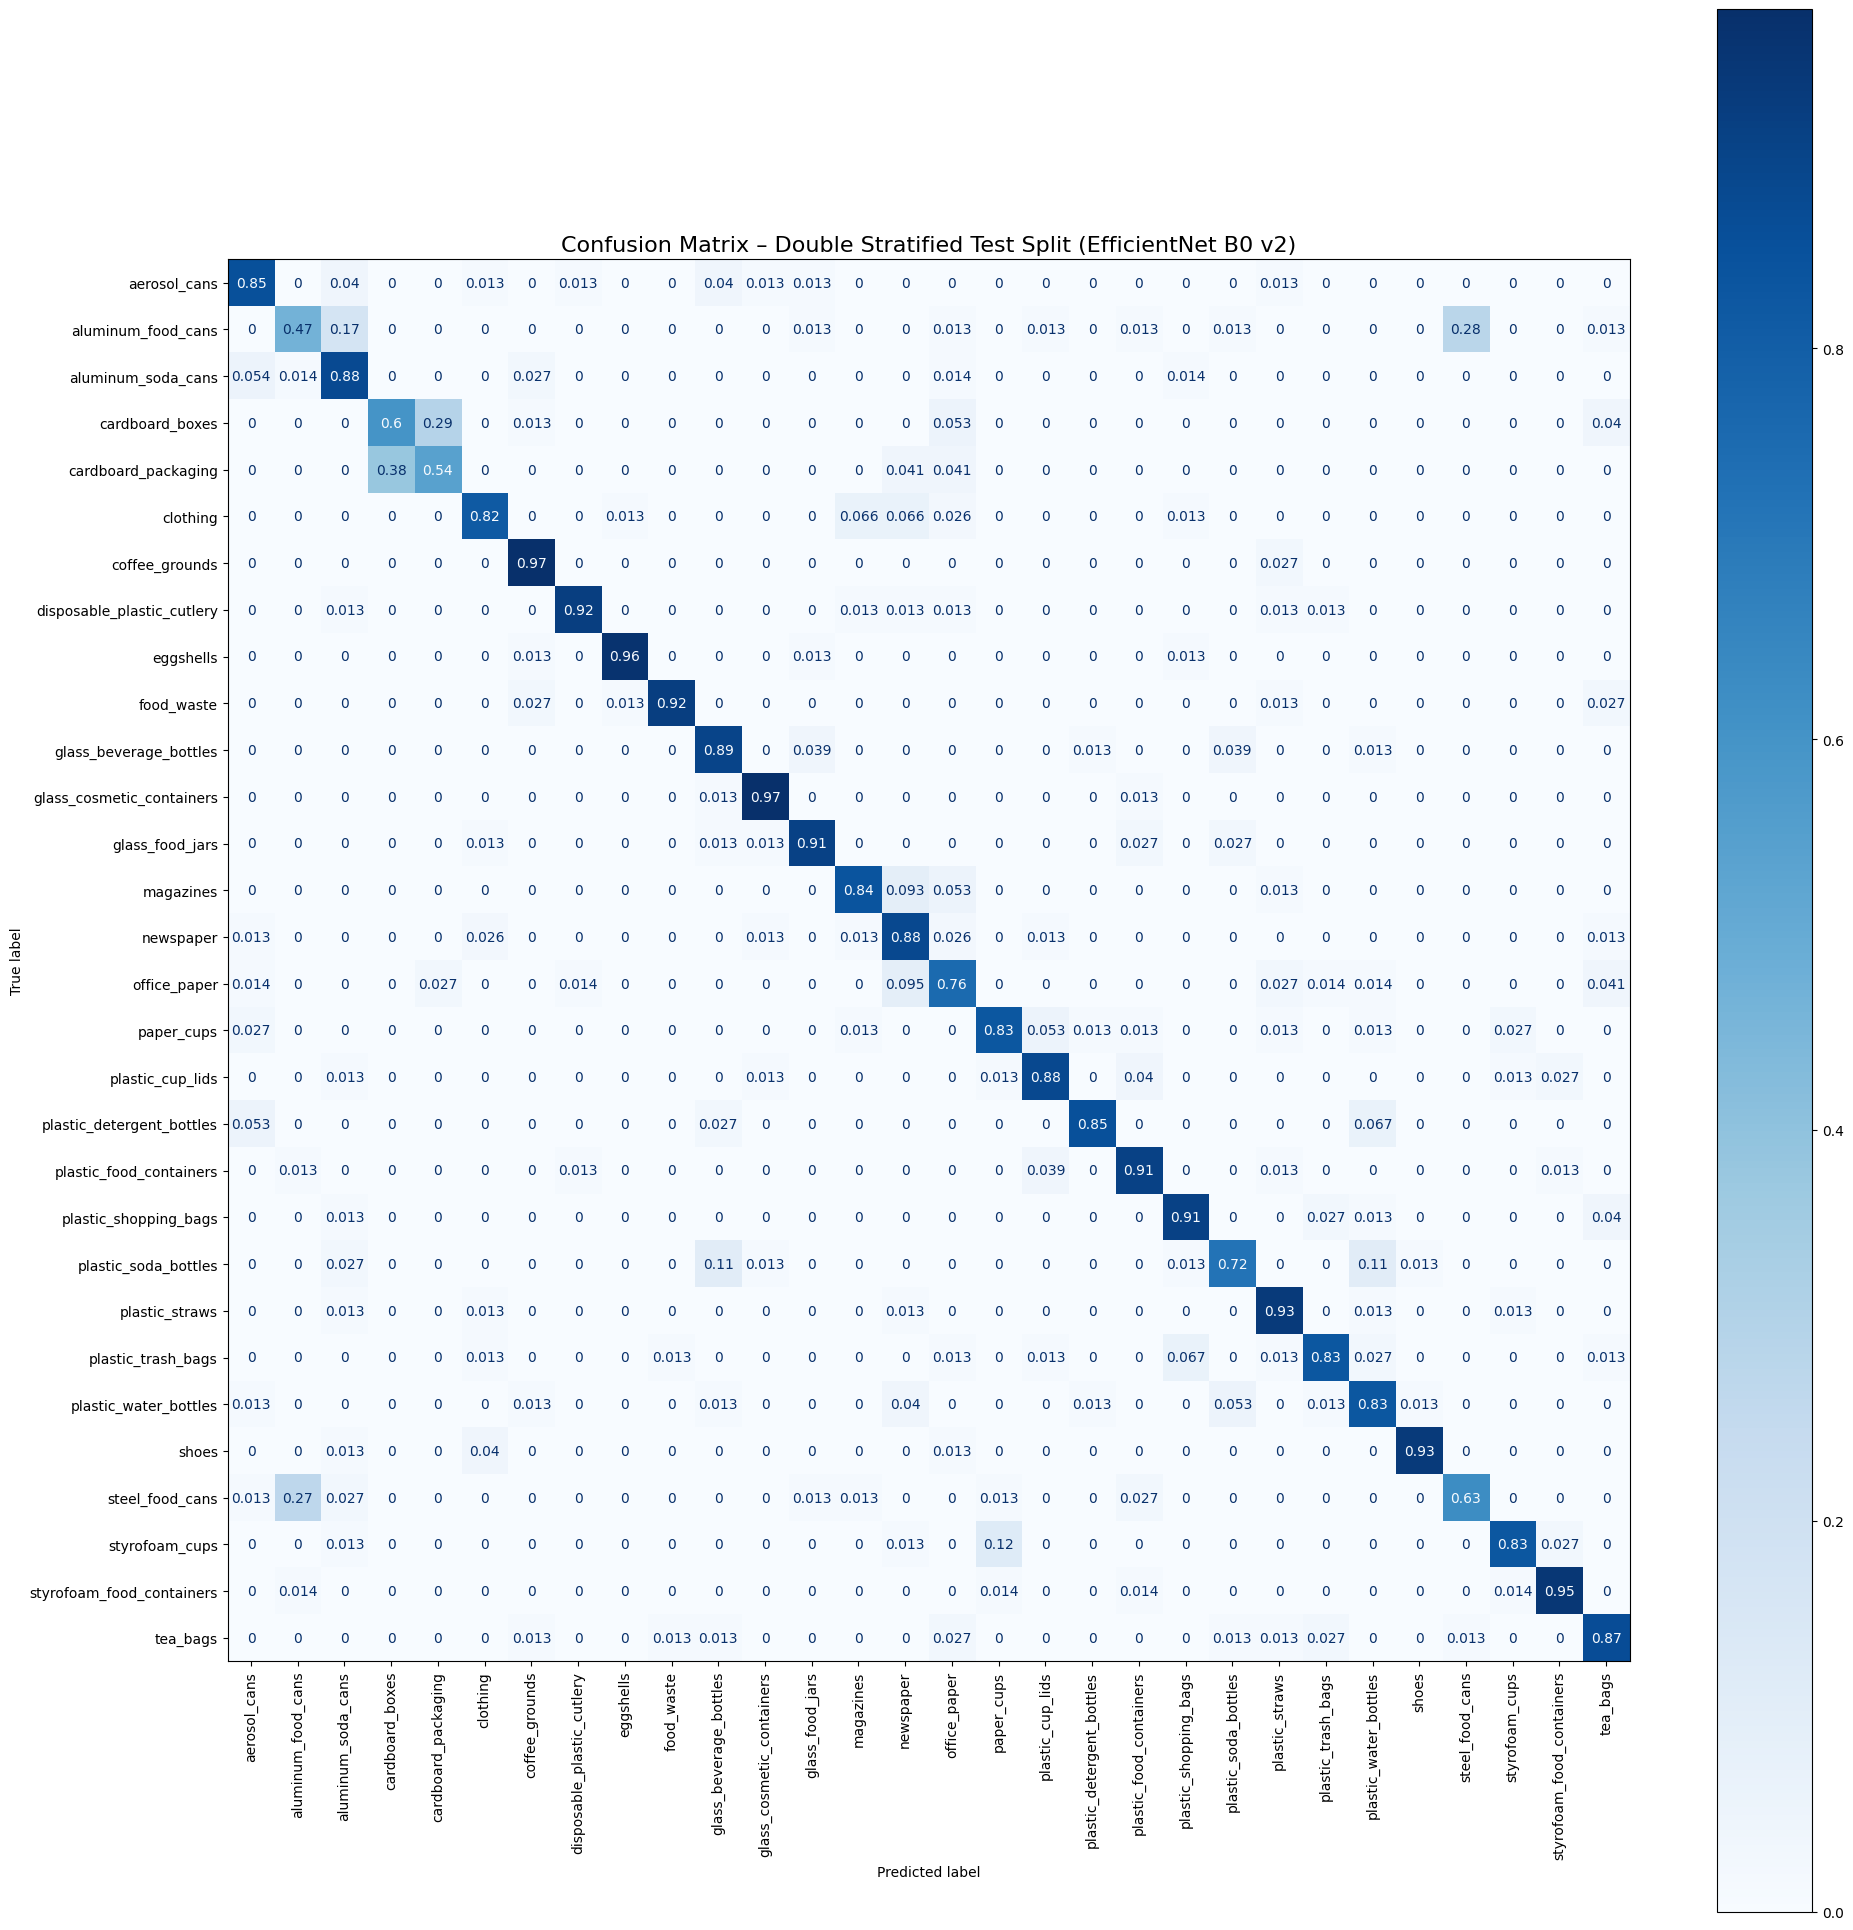

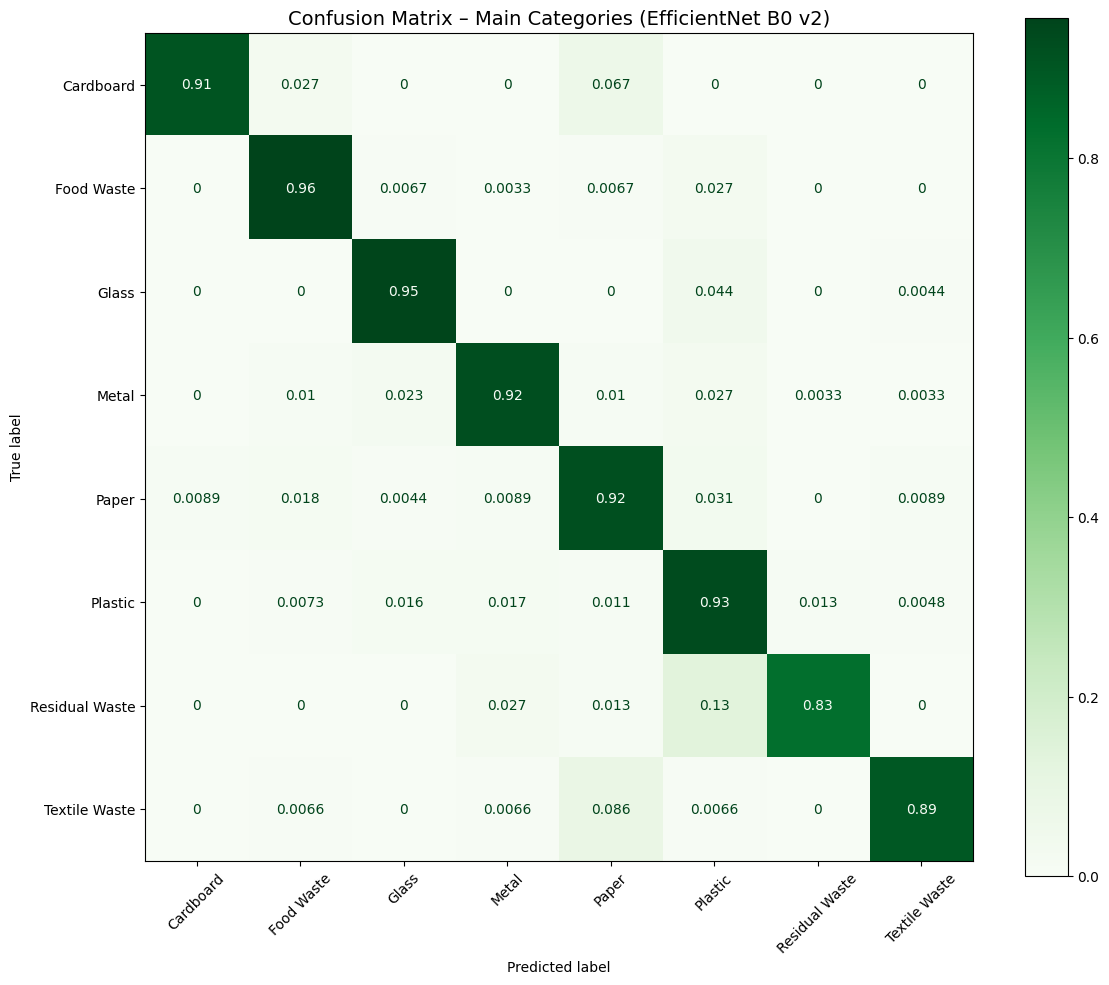


🔍 Per-Class Accuracy Breakdown (EfficientNet B0 v2):
---------------------------------------------
aerosol_cans                   — Accuracy: 85.33%
aluminum_food_cans             — Accuracy: 46.67%
aluminum_soda_cans             — Accuracy: 87.84%
cardboard_boxes                — Accuracy: 60.00%
cardboard_packaging            — Accuracy: 54.05%
clothing                       — Accuracy: 81.58%
coffee_grounds                 — Accuracy: 97.30%
disposable_plastic_cutlery     — Accuracy: 92.00%
eggshells                      — Accuracy: 96.00%
food_waste                     — Accuracy: 92.00%
glass_beverage_bottles         — Accuracy: 89.47%
glass_cosmetic_containers      — Accuracy: 97.37%
glass_food_jars                — Accuracy: 90.67%
magazines                      — Accuracy: 84.00%
newspaper                      — Accuracy: 88.16%
office_paper                   — Accuracy: 75.68%
paper_cups                     — Accuracy: 82.67%
plastic_cup_lids               — Accuracy: 88.00%


In [16]:
from torchvision import models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ----------------------
# Load EfficientNet B0 v2 Architecture
# ----------------------
model_b0v2 = models.efficientnet_b0(pretrained=True)
for param in model_b0v2.parameters():
    param.requires_grad = True  # ✅ Fine-tuned version

# ✅ Reconstruct the same classifier head used in training
model_b0v2.classifier[1] = nn.Sequential(
    nn.Linear(model_b0v2.classifier[1].in_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, num_classes)
)
model_b0v2 = model_b0v2.to(device)

# ✅ Load the trained weights
model_b0v2.load_state_dict(torch.load("best_efficientnet_model_v2.pt"))
model_b0v2.eval()

# ----------------------
# Initialize Tracking
# ----------------------
b0v2_class_correct = [0] * num_classes
b0v2_class_total = [0] * num_classes
b0v2_default_correct = b0v2_real_correct = 0
b0v2_default_total = b0v2_real_total = 0
b0v2_all_preds = []
b0v2_all_labels = []

# Mapping class index to category name
idx_to_class = {i: name for i, name in enumerate(full_dataset_val.classes)}
idx_to_main_category = {
    i: subcategory_to_main_category[name]
    for i, name in idx_to_class.items()
}

b0v2_adj_correct = 0
b0v2_adj_total = 0
b0v2_all_preds_main = []
b0v2_all_labels_main = []

# ----------------------
# Evaluation Loop
# ----------------------
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model_b0v2(images)
        _, predicted = torch.max(outputs, 1)

        for j in range(len(labels)):
            true_label = labels[j].item()
            pred_label = predicted[j].item()

            # Per-class accuracy
            b0v2_class_total[true_label] += 1
            if true_label == pred_label:
                b0v2_class_correct[true_label] += 1

            # Type-based accuracy
            img_index = i * test_loader.batch_size + j
            path = test_paths[img_index]
            if "default" in path:
                b0v2_default_total += 1
                if true_label == pred_label:
                    b0v2_default_correct += 1
            elif "real_world" in path:
                b0v2_real_total += 1
                if true_label == pred_label:
                    b0v2_real_correct += 1

            # Adjusted Accuracy
            true_main = idx_to_main_category[true_label]
            pred_main = idx_to_main_category[pred_label]
            if true_main == pred_main:
                b0v2_adj_correct += 1
            b0v2_adj_total += 1

            # For confusion matrix
            b0v2_all_preds.append(pred_label)
            b0v2_all_labels.append(true_label)
            b0v2_all_preds_main.append(pred_main)
            b0v2_all_labels_main.append(true_main)

# ----------------------
# Confusion Matrix (Subclass)
# ----------------------
cm_b0v2 = confusion_matrix(b0v2_all_labels, b0v2_all_preds, normalize="true")
disp_b0v2 = ConfusionMatrixDisplay(confusion_matrix=cm_b0v2, display_labels=full_dataset_val.classes)

fig, ax = plt.subplots(figsize=(20, 20))
disp_b0v2.plot(ax=ax, xticks_rotation=90, cmap="Blues", colorbar=True)
ax.set_xticklabels(full_dataset_val.classes, fontsize=10, rotation=90)
ax.set_yticklabels(full_dataset_val.classes, fontsize=10)
plt.title("Confusion Matrix – Double Stratified Test Split (EfficientNet B0 v2)", fontsize=16)
plt.tight_layout()
plt.show()

# ----------------------
# Confusion Matrix (Main Categories)
# ----------------------
main_categories = sorted(set(b0v2_all_labels_main + b0v2_all_preds_main))
cm_b0v2_main = confusion_matrix(b0v2_all_labels_main, b0v2_all_preds_main, labels=main_categories, normalize="true")
disp_b0v2_main = ConfusionMatrixDisplay(confusion_matrix=cm_b0v2_main, display_labels=main_categories)

fig, ax = plt.subplots(figsize=(12, 10))
disp_b0v2_main.plot(ax=ax, cmap="Greens", xticks_rotation=45)
plt.title("Confusion Matrix – Main Categories (EfficientNet B0 v2)", fontsize=14)
plt.tight_layout()
plt.show()

# ----------------------
# Accuracy Reporting
# ----------------------
print("\n🔍 Per-Class Accuracy Breakdown (EfficientNet B0 v2):\n" + "-" * 45)
for i, class_name in enumerate(full_dataset_val.classes):
    acc = 100 * b0v2_class_correct[i] / b0v2_class_total[i] if b0v2_class_total[i] > 0 else 0.0
    print(f"{class_name:30s} — Accuracy: {acc:.2f}%")

b0v2_default_acc = 100 * b0v2_default_correct / b0v2_default_total if b0v2_default_total > 0 else 0.0
b0v2_real_acc = 100 * b0v2_real_correct / b0v2_real_total if b0v2_real_total > 0 else 0.0

print("\n📸 Accuracy by Photo Type (EfficientNet B0 v2):\n" + "-" * 45)
print(f"Default Photos      — Accuracy: {b0v2_default_acc:.2f}% ({b0v2_default_correct}/{b0v2_default_total})")
print(f"Real-World Photos   — Accuracy: {b0v2_real_acc:.2f}% ({b0v2_real_correct}/{b0v2_real_total})")

b0v2_overall_acc = 100 * sum(b0v2_class_correct) / sum(b0v2_class_total)
print(f"\n✅ Overall Accuracy (EfficientNet B0 v2): {b0v2_overall_acc:.2f}%")

b0v2_adj_accuracy = 100 * b0v2_adj_correct / b0v2_adj_total
print(f"🎯 Adjusted Accuracy (Grouped by Main Categories): {b0v2_adj_accuracy:.2f}%")


In [1]:
import torch
import torch.nn as nn
from torchvision import models

# ----------------------
# DEVICE SETUP
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------
# REBUILD ARCHITECTURE
# ----------------------
num_classes = 30  # <-- Replace with your number of classes if different!

model_b0v2 = models.efficientnet_b0(pretrained=True)

# Fine-tune all layers
for param in model_b0v2.parameters():
    param.requires_grad = True

# Classifier head used during your training
model_b0v2.classifier[1] = nn.Sequential(
    nn.Linear(model_b0v2.classifier[1].in_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, num_classes)
)

model_b0v2 = model_b0v2.to(device)

# ----------------------
# LOAD TRAINED WEIGHTS
# ----------------------
model_b0v2.load_state_dict(torch.load("best_efficientnet_model_v2.pt"))
model_b0v2.eval()

print("✅ Model rebuilt and weights loaded successfully.")

# ----------------------
# SAVE FULL MODEL (ARCHITECTURE + WEIGHTS)
# ----------------------
torch.save(model_b0v2, "full_efficientnet_model_v2.pth")

print("✅ Full model saved as 'full_efficientnet_model_v2.pth'.")


Using device: cpu
✅ Model rebuilt and weights loaded successfully.
✅ Full model saved as 'full_efficientnet_model_v2.pth'.


/Users/lukestockbridge/miniconda3/envs/nn/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/lukestockbridge/miniconda3/envs/nn/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
import torch
import torch.nn as nn
from torchvision import models

# DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# BUILD MODEL
num_classes = 30
model_b0v2 = models.efficientnet_b0(pretrained=True)

# Freeze all first
for param in model_b0v2.parameters():
    param.requires_grad = False

# Unfreeze only features.6, features.7, and classifier layers
for name, param in model_b0v2.named_parameters():
    if "features.6" in name or "features.7" in name or "classifier" in name:
        param.requires_grad = True

# Same deeper classifier head
model_b0v2.classifier[1] = nn.Sequential(
    nn.Linear(model_b0v2.classifier[1].in_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, num_classes)
)

model_b0v2 = model_b0v2.to(device)

# LOAD TRAINED WEIGHTS
model_b0v2.load_state_dict(torch.load("best_efficientnet_model_v2.pt", map_location=device))
model_b0v2.eval()

print("✅ Correct model architecture rebuilt and weights loaded.")

# SAVE FULL MODEL
torch.save(model_b0v2, "full_efficientnet_model_v3.pth")
print("✅ Full correct model saved as 'full_efficientnet_model_v3.pth'")


✅ Correct model architecture rebuilt and weights loaded.
✅ Full correct model saved as 'full_efficientnet_model_v3.pth'


# MODEL 6.5 FROM MAIN RERUN

Using device: cpu

Epoch 1/30


→ Train Loss: 2.8861 | Val Loss: 2.3034

Epoch 2/30


→ Train Loss: 1.9581 | Val Loss: 1.7829

Epoch 3/30


→ Train Loss: 1.2723 | Val Loss: 1.6030

Epoch 4/30


→ Train Loss: 0.7298 | Val Loss: 1.6126

Epoch 5/30


→ Train Loss: 0.4281 | Val Loss: 1.7086

Epoch 6/30


→ Train Loss: 1.6865 | Val Loss: 1.3584

Epoch 7/30


→ Train Loss: 1.2936 | Val Loss: 1.2827

Epoch 8/30


→ Train Loss: 1.0643 | Val Loss: 1.2918

Epoch 9/30


→ Train Loss: 0.9322 | Val Loss: 1.3450

Epoch 10/30


→ Train Loss: 0.7937 | Val Loss: 1.3708

Epoch 11/30


→ Train Loss: 0.5980 | Val Loss: 1.3699

Epoch 12/30


→ Train Loss: 0.5045 | Val Loss: 1.4131

Epoch 13/30


→ Train Loss: 0.4502 | Val Loss: 1.4264
Early stopping triggered after 13 epochs.


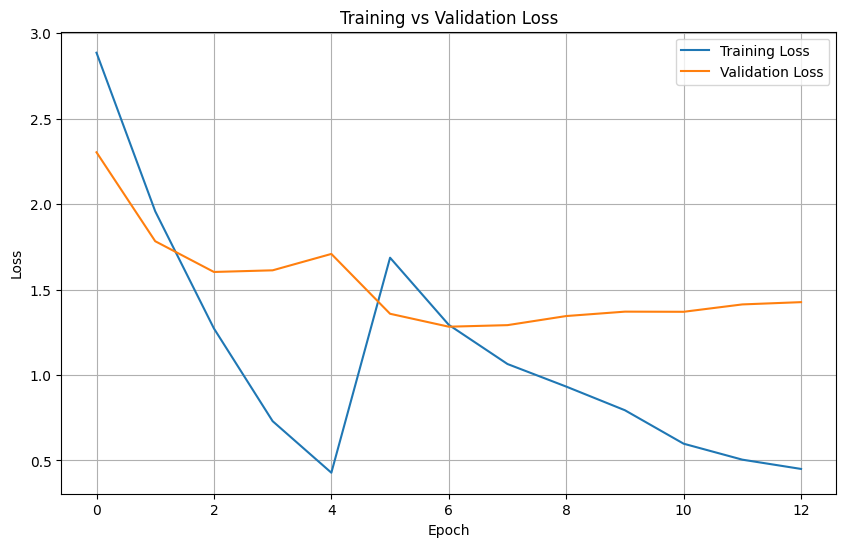

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# ----------------------
# DEVICE SETUP
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------
# TRANSFORMS
# ----------------------
transform_augmented = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

transform_plain = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# ----------------------
# DATASETS USING EXISTING SPLITS
# ----------------------
base_train_dataset = ImageFolder("images/", transform=transform_plain)
val_dataset = ImageFolder("images/", transform=transform_plain)

train_idx = double_strat_train_dataset.indices
val_idx = double_strat_val_dataset.indices

# ----------------------
# MODEL DEFINITION
# ----------------------
class WasteClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super(WasteClassifierCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flattened_size = 128 * 32 * 32  # For 256x256 input and 3 pools
        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.dropout = nn.Dropout(0.2)  # Slightly softened dropout
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# ----------------------
# INITIALIZATION
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(base_train_dataset.classes)
model = WasteClassifierCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# ----------------------
# TRAINING LOOP
# ----------------------
num_epochs = 30
patience = 6
best_val_loss = float('inf')
patience_counter = 0
history = {"loss": [], "val_loss": []}

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Delayed augmentation: switch after epoch 5
    base_train_dataset.transform = transform_augmented if epoch >= 5 else transform_plain

    train_loader = DataLoader(Subset(base_train_dataset, train_idx), batch_size=32, shuffle=True)
    val_loader = DataLoader(Subset(val_dataset, val_idx), batch_size=32, shuffle=False)

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, total=len(train_loader), leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loop.set_postfix({
            "acc": f"{(correct / total):.4f}",
            "loss": f"{running_loss / (loop.n + 1):.4f}"
        })

    train_loss = running_loss / len(train_loader)
    history["loss"].append(train_loss)

    # ----------------------
    # VALIDATION
    # ----------------------
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
    val_loss /= len(val_loader)
    history["val_loss"].append(val_loss)

    print(f"→ Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    scheduler.step()

    # ----------------------
    # EARLY STOPPING
    # ----------------------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "second_model6.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

# ----------------------
# PLOT LOSS CURVES
# ----------------------
plt.figure(figsize=(10, 6))
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


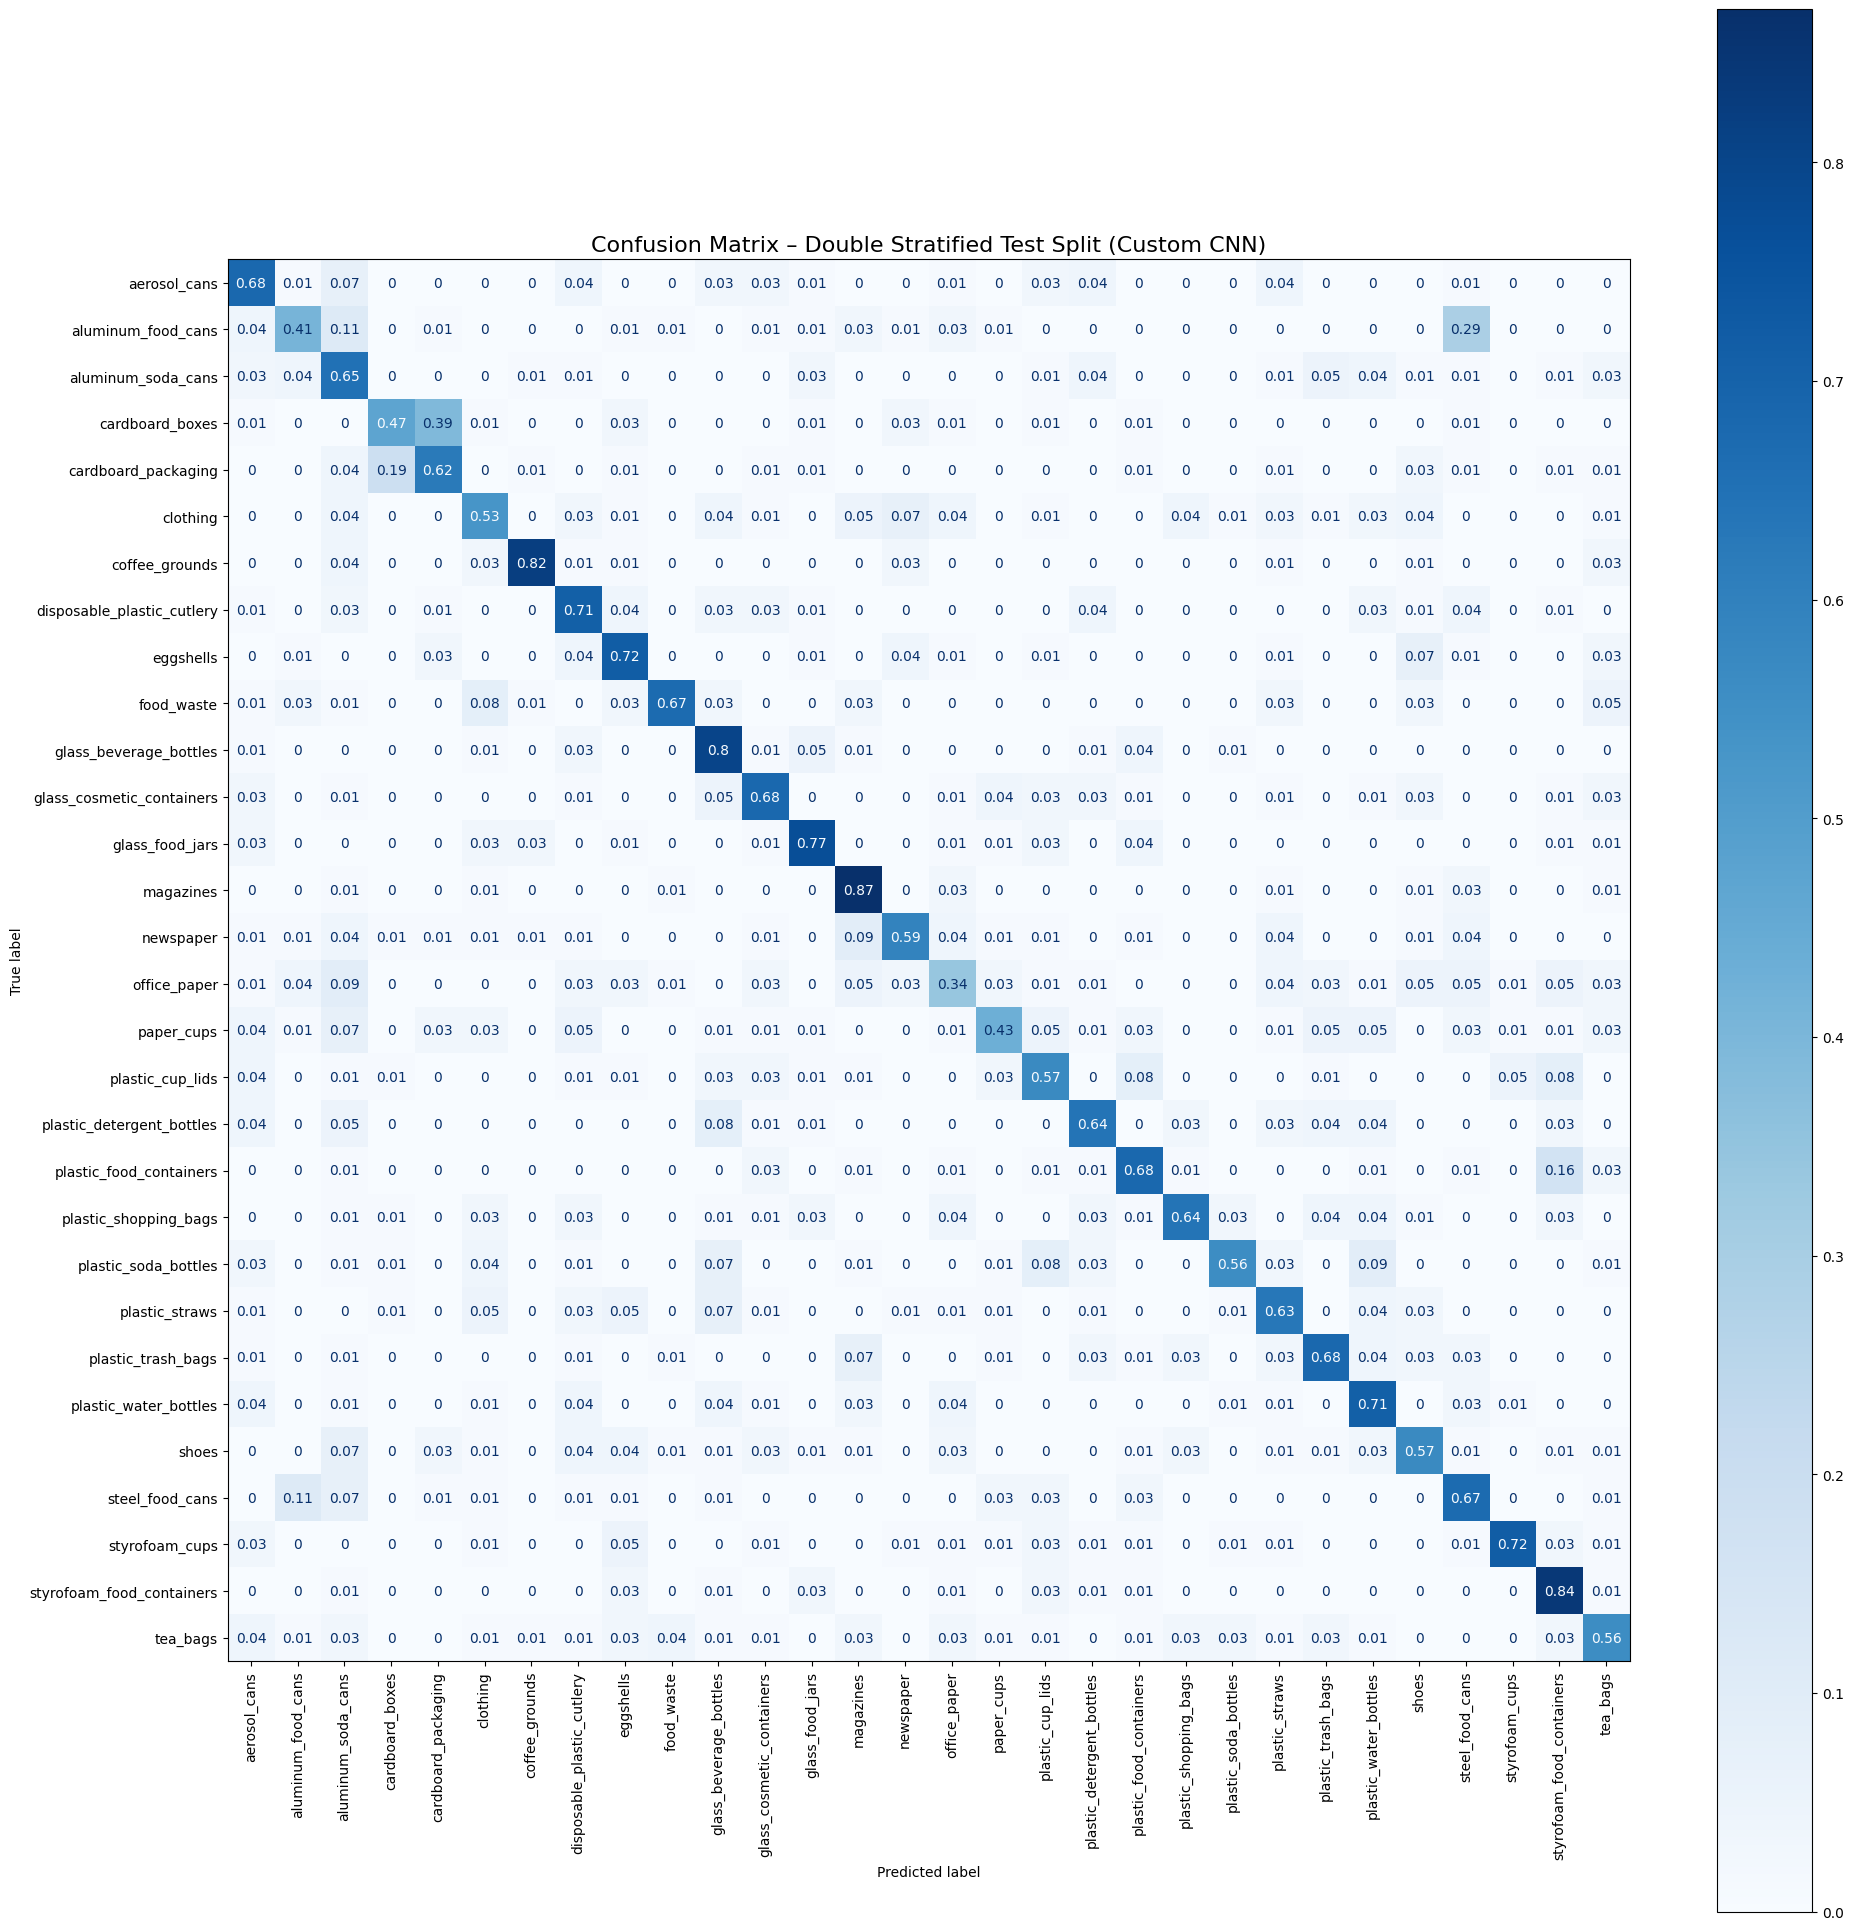


🔍 Per-Class Accuracy Breakdown (Custom CNN):
----------------------------------------
aerosol_cans                   — Accuracy: 68.00%
aluminum_food_cans             — Accuracy: 41.33%
aluminum_soda_cans             — Accuracy: 64.86%
cardboard_boxes                — Accuracy: 46.67%
cardboard_packaging            — Accuracy: 62.16%
clothing                       — Accuracy: 52.63%
coffee_grounds                 — Accuracy: 82.43%
disposable_plastic_cutlery     — Accuracy: 70.67%
eggshells                      — Accuracy: 72.00%
food_waste                     — Accuracy: 66.67%
glass_beverage_bottles         — Accuracy: 80.26%
glass_cosmetic_containers      — Accuracy: 68.42%
glass_food_jars                — Accuracy: 77.33%
magazines                      — Accuracy: 86.67%
newspaper                      — Accuracy: 59.21%
office_paper                   — Accuracy: 33.78%
paper_cups                     — Accuracy: 42.67%
plastic_cup_lids               — Accuracy: 57.33%
plastic_deter

In [9]:
# ----------------------
# MODEL DEFINITION FOR MODEL 6.5 (No BatchNorm)
# ----------------------
class WasteClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super(WasteClassifierCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)  # Match training dropout
        self.flattened_size = 128 * 32 * 32
        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


# ----------------------
# LOAD BEST SAVED WEIGHTS
# ----------------------
custom_model = WasteClassifierCNN(num_classes).to(device)
custom_model.load_state_dict(torch.load("second_model6.pt"))
custom_model.eval()
# ----------------------
# TEST DATA LOADER + PATHS
# ----------------------
test_loader = DataLoader(torch.utils.data.Subset(val_dataset, double_strat_test_dataset.indices), batch_size=32, shuffle=False)
test_paths_custom = [val_dataset.samples[i][0] for i in double_strat_test_dataset.indices]

# ----------------------
# ACCURACY TRACKING
# ----------------------
custom_class_correct = [0] * num_classes
custom_class_total = [0] * num_classes
custom_default_correct = 0
custom_default_total = 0
custom_real_correct = 0
custom_real_total = 0
custom_all_preds = []
custom_all_labels = []

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = custom_model(images)
        _, predicted = torch.max(outputs, 1)

        for j in range(len(labels)):
            true_label = labels[j]
            pred_label = predicted[j]
            custom_class_total[true_label] += 1
            if true_label == pred_label:
                custom_class_correct[true_label] += 1

            path = test_paths_custom[i * test_loader.batch_size + j]
            if "default" in path:
                custom_default_total += 1
                if true_label == pred_label:
                    custom_default_correct += 1
            elif "real_world" in path:
                custom_real_total += 1
                if true_label == pred_label:
                    custom_real_correct += 1

            custom_all_preds.append(pred_label.cpu())
            custom_all_labels.append(true_label.cpu())

# ----------------------
# CONFUSION MATRIX (Normalized)
# ----------------------
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

custom_cm = confusion_matrix(custom_all_labels, custom_all_preds, normalize="true")
custom_cm = np.round(custom_cm, 2)
custom_disp = ConfusionMatrixDisplay(confusion_matrix=custom_cm, display_labels=val_dataset.classes)

fig, ax = plt.subplots(figsize=(20, 20))
custom_disp.plot(ax=ax, xticks_rotation=90, cmap="Blues", colorbar=True)
ax.set_xticklabels(val_dataset.classes, fontsize=10, rotation=90)
ax.set_yticklabels(val_dataset.classes, fontsize=10)
plt.title("Confusion Matrix – Double Stratified Test Split (Custom CNN)", fontsize=16)
plt.tight_layout()
plt.show()

# ----------------------
# PER-CLASS ACCURACY
# ----------------------
print("\n🔍 Per-Class Accuracy Breakdown (Custom CNN):\n" + "-" * 40)
for i, class_name in enumerate(val_dataset.classes):
    acc = 100 * custom_class_correct[i] / custom_class_total[i] if custom_class_total[i] > 0 else 0.0
    print(f"{class_name:30s} — Accuracy: {acc:.2f}%")

# ----------------------
# TYPE-BASED ACCURACY
# ----------------------
custom_default_acc = 100 * custom_default_correct / custom_default_total if custom_default_total > 0 else 0.0
custom_real_acc = 100 * custom_real_correct / custom_real_total if custom_real_total > 0 else 0.0

print("\n📸 Accuracy by Photo Type (Custom CNN):\n" + "-" * 40)
print(f"Default Photos      — Accuracy: {custom_default_acc:.2f}% ({custom_default_correct}/{custom_default_total})")
print(f"Real-World Photos   — Accuracy: {custom_real_acc:.2f}% ({custom_real_correct}/{custom_real_total})")

# ----------------------
# OVERALL TEST ACCURACY
# ----------------------
custom_overall_acc = 100 * sum(custom_class_correct) / sum(custom_class_total)
print(f"\n✅ Overall Test Accuracy (Custom CNN - Double Stratified): {custom_overall_acc:.2f}%")


# MODEL 6.75 - ATTEMPTING TO IMPROVE ON 6.5

Using device: cpu

Epoch 1/30


→ Train Loss: 2.9839 | Val Loss: 2.5527

Epoch 2/30


→ Train Loss: 2.4577 | Val Loss: 2.3280

Epoch 3/30


→ Train Loss: 2.1962 | Val Loss: 2.1079

Epoch 4/30


→ Train Loss: 2.0037 | Val Loss: 1.9524

Epoch 5/30


→ Train Loss: 1.8362 | Val Loss: 1.8859

Epoch 6/30


→ Train Loss: 1.6774 | Val Loss: 1.7384

Epoch 7/30


→ Train Loss: 1.5391 | Val Loss: 1.6222

Epoch 8/30


→ Train Loss: 1.4104 | Val Loss: 1.7063

Epoch 9/30


→ Train Loss: 1.3056 | Val Loss: 1.5824

Epoch 10/30


→ Train Loss: 1.1963 | Val Loss: 1.6111

Epoch 11/30


→ Train Loss: 1.0078 | Val Loss: 1.5137

Epoch 12/30


→ Train Loss: 0.9251 | Val Loss: 1.5658

Epoch 13/30


→ Train Loss: 0.8671 | Val Loss: 1.5979

Epoch 14/30


→ Train Loss: 0.8310 | Val Loss: 1.5684

Epoch 15/30


→ Train Loss: 0.7685 | Val Loss: 1.5823

Epoch 16/30


→ Train Loss: 0.7360 | Val Loss: 1.6042

Epoch 17/30


→ Train Loss: 0.7068 | Val Loss: 1.5947
Early stopping triggered after 17 epochs.


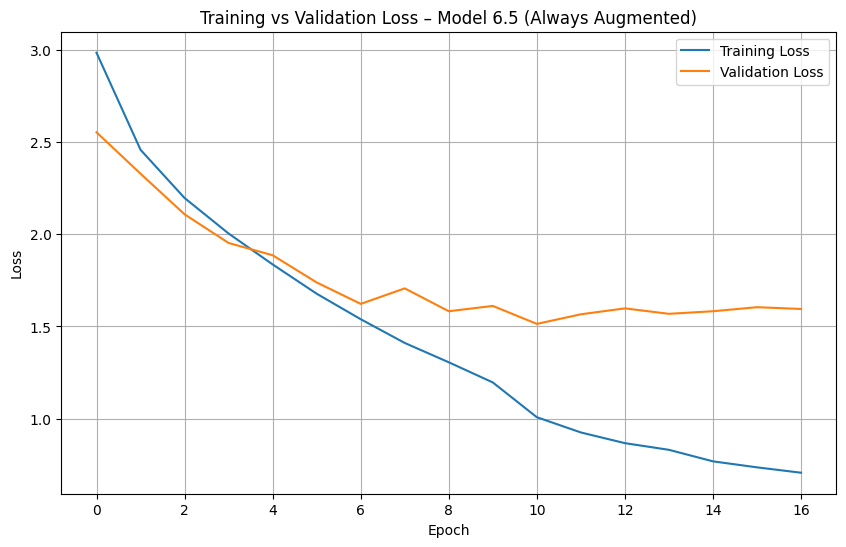

In [10]:
# ----------------------
# DEVICE SETUP
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------
# TRANSFORMS
# ----------------------
transform_augmented = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

transform_plain = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# ----------------------
# DATASETS USING EXISTING SPLITS
# ----------------------
base_train_dataset = ImageFolder("images/", transform=transform_augmented)  # Always augmented
val_dataset = ImageFolder("images/", transform=transform_plain)

train_idx = double_strat_train_dataset.indices
val_idx = double_strat_val_dataset.indices

# ----------------------
# MODEL DEFINITION (Model 6.5)
# ----------------------
class WasteClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super(WasteClassifierCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flattened_size = 128 * 32 * 32
        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.dropout = nn.Dropout(0.2)  # Slightly softened
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# ----------------------
# INITIALIZATION
# ----------------------
num_classes = len(base_train_dataset.classes)
model = WasteClassifierCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# ----------------------
# TRAINING LOOP
# ----------------------
num_epochs = 30
patience = 6
best_val_loss = float('inf')
patience_counter = 0
history = {"loss": [], "val_loss": []}

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    train_loader = DataLoader(Subset(base_train_dataset, train_idx), batch_size=32, shuffle=True)
    val_loader = DataLoader(Subset(val_dataset, val_idx), batch_size=32, shuffle=False)

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, total=len(train_loader), leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loop.set_postfix({
            "acc": f"{(correct / total):.4f}",
            "loss": f"{running_loss / (loop.n + 1):.4f}"
        })

    train_loss = running_loss / len(train_loader)
    history["loss"].append(train_loss)

    # ----------------------
    # VALIDATION
    # ----------------------
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
    val_loss /= len(val_loader)
    history["val_loss"].append(val_loss)

    print(f"→ Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    scheduler.step()

    # ----------------------
    # EARLY STOPPING
    # ----------------------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "model6_5_always_aug.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

# ----------------------
# PLOT LOSS CURVES
# ----------------------
plt.figure(figsize=(10, 6))
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss – Model 6.5 (Always Augmented)")
plt.legend()
plt.grid(True)
plt.show()


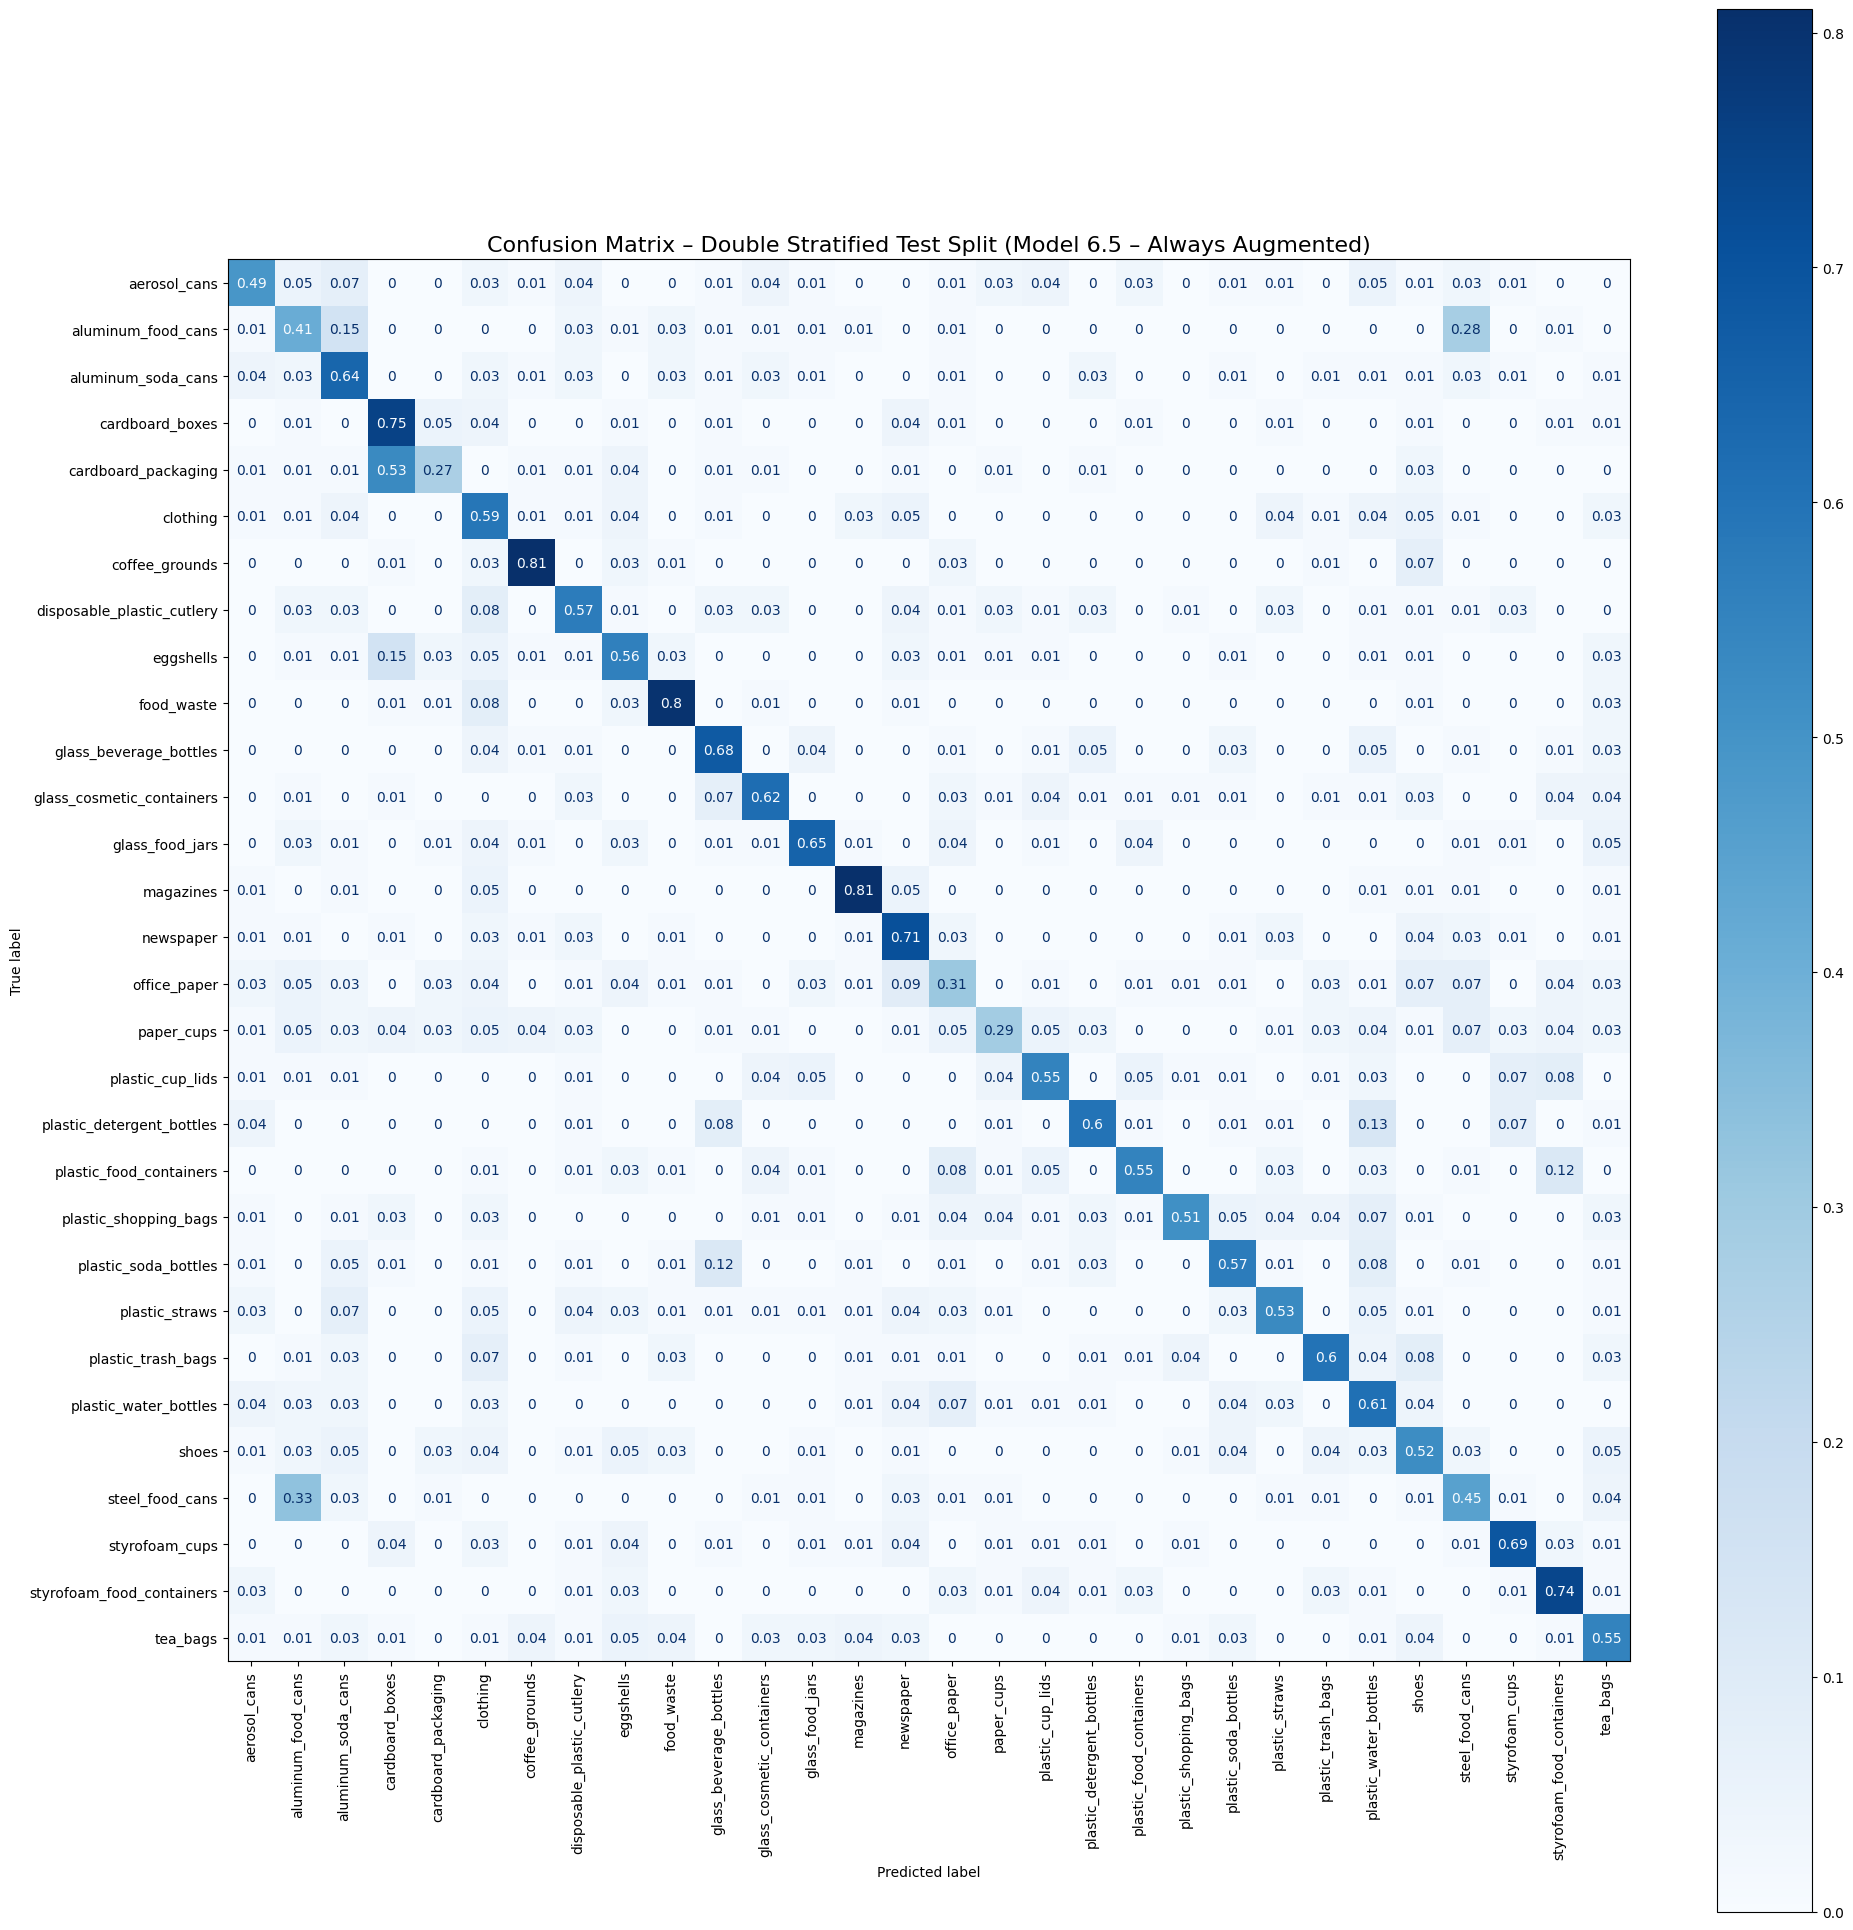


🔍 Per-Class Accuracy Breakdown (Model 6.5 – Always Augmented):
----------------------------------------
aerosol_cans                   — Accuracy: 49.33%
aluminum_food_cans             — Accuracy: 41.33%
aluminum_soda_cans             — Accuracy: 63.51%
cardboard_boxes                — Accuracy: 74.67%
cardboard_packaging            — Accuracy: 27.03%
clothing                       — Accuracy: 59.21%
coffee_grounds                 — Accuracy: 81.08%
disposable_plastic_cutlery     — Accuracy: 57.33%
eggshells                      — Accuracy: 56.00%
food_waste                     — Accuracy: 80.00%
glass_beverage_bottles         — Accuracy: 68.42%
glass_cosmetic_containers      — Accuracy: 61.84%
glass_food_jars                — Accuracy: 65.33%
magazines                      — Accuracy: 81.33%
newspaper                      — Accuracy: 71.05%
office_paper                   — Accuracy: 31.08%
paper_cups                     — Accuracy: 29.33%
plastic_cup_lids               — Accuracy: 54

In [11]:
# ----------------------
# MODEL DEFINITION (Match training config)
# ----------------------
class WasteClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super(WasteClassifierCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flattened_size = 128 * 32 * 32
        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# ----------------------
# LOAD BEST SAVED WEIGHTS
# ----------------------
custom_model = WasteClassifierCNN(num_classes).to(device)
custom_model.load_state_dict(torch.load("model6_5_always_aug.pt"))
custom_model.eval()

# ----------------------
# TEST DATA LOADER + PATHS
# ----------------------
test_loader = DataLoader(torch.utils.data.Subset(val_dataset, double_strat_test_dataset.indices), batch_size=32, shuffle=False)
test_paths_custom = [val_dataset.samples[i][0] for i in double_strat_test_dataset.indices]

# ----------------------
# ACCURACY TRACKING
# ----------------------
custom_class_correct = [0] * num_classes
custom_class_total = [0] * num_classes
custom_default_correct = 0
custom_default_total = 0
custom_real_correct = 0
custom_real_total = 0
custom_all_preds = []
custom_all_labels = []

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = custom_model(images)
        _, predicted = torch.max(outputs, 1)

        for j in range(len(labels)):
            true_label = labels[j]
            pred_label = predicted[j]
            custom_class_total[true_label] += 1
            if true_label == pred_label:
                custom_class_correct[true_label] += 1

            path = test_paths_custom[i * test_loader.batch_size + j]
            if "default" in path:
                custom_default_total += 1
                if true_label == pred_label:
                    custom_default_correct += 1
            elif "real_world" in path:
                custom_real_total += 1
                if true_label == pred_label:
                    custom_real_correct += 1

            custom_all_preds.append(pred_label.cpu())
            custom_all_labels.append(true_label.cpu())

# ----------------------
# CONFUSION MATRIX (Normalized)
# ----------------------
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

custom_cm = confusion_matrix(custom_all_labels, custom_all_preds, normalize="true")
custom_cm = np.round(custom_cm, 2)
custom_disp = ConfusionMatrixDisplay(confusion_matrix=custom_cm, display_labels=val_dataset.classes)

fig, ax = plt.subplots(figsize=(20, 20))
custom_disp.plot(ax=ax, xticks_rotation=90, cmap="Blues", colorbar=True)
ax.set_xticklabels(val_dataset.classes, fontsize=10, rotation=90)
ax.set_yticklabels(val_dataset.classes, fontsize=10)
plt.title("Confusion Matrix – Double Stratified Test Split (Model 6.5 – Always Augmented)", fontsize=16)
plt.tight_layout()
plt.show()

# ----------------------
# PER-CLASS ACCURACY
# ----------------------
print("\n🔍 Per-Class Accuracy Breakdown (Model 6.5 – Always Augmented):\n" + "-" * 40)
for i, class_name in enumerate(val_dataset.classes):
    acc = 100 * custom_class_correct[i] / custom_class_total[i] if custom_class_total[i] > 0 else 0.0
    print(f"{class_name:30s} — Accuracy: {acc:.2f}%")

# ----------------------
# TYPE-BASED ACCURACY
# ----------------------
custom_default_acc = 100 * custom_default_correct / custom_default_total if custom_default_total > 0 else 0.0
custom_real_acc = 100 * custom_real_correct / custom_real_total if custom_real_total > 0 else 0.0

print("\n📸 Accuracy by Photo Type (Model 6.5 – Always Augmented):\n" + "-" * 40)
print(f"Default Photos      — Accuracy: {custom_default_acc:.2f}% ({custom_default_correct}/{custom_default_total})")
print(f"Real-World Photos   — Accuracy: {custom_real_acc:.2f}% ({custom_real_correct}/{custom_real_total})")

# ----------------------
# OVERALL TEST ACCURACY
# ----------------------
custom_overall_acc = 100 * sum(custom_class_correct) / sum(custom_class_total)
print(f"\n✅ Overall Test Accuracy (Model 6.5 – Always Augmented): {custom_overall_acc:.2f}%")


# MEGA ANALYSIS OF BEST MODEL

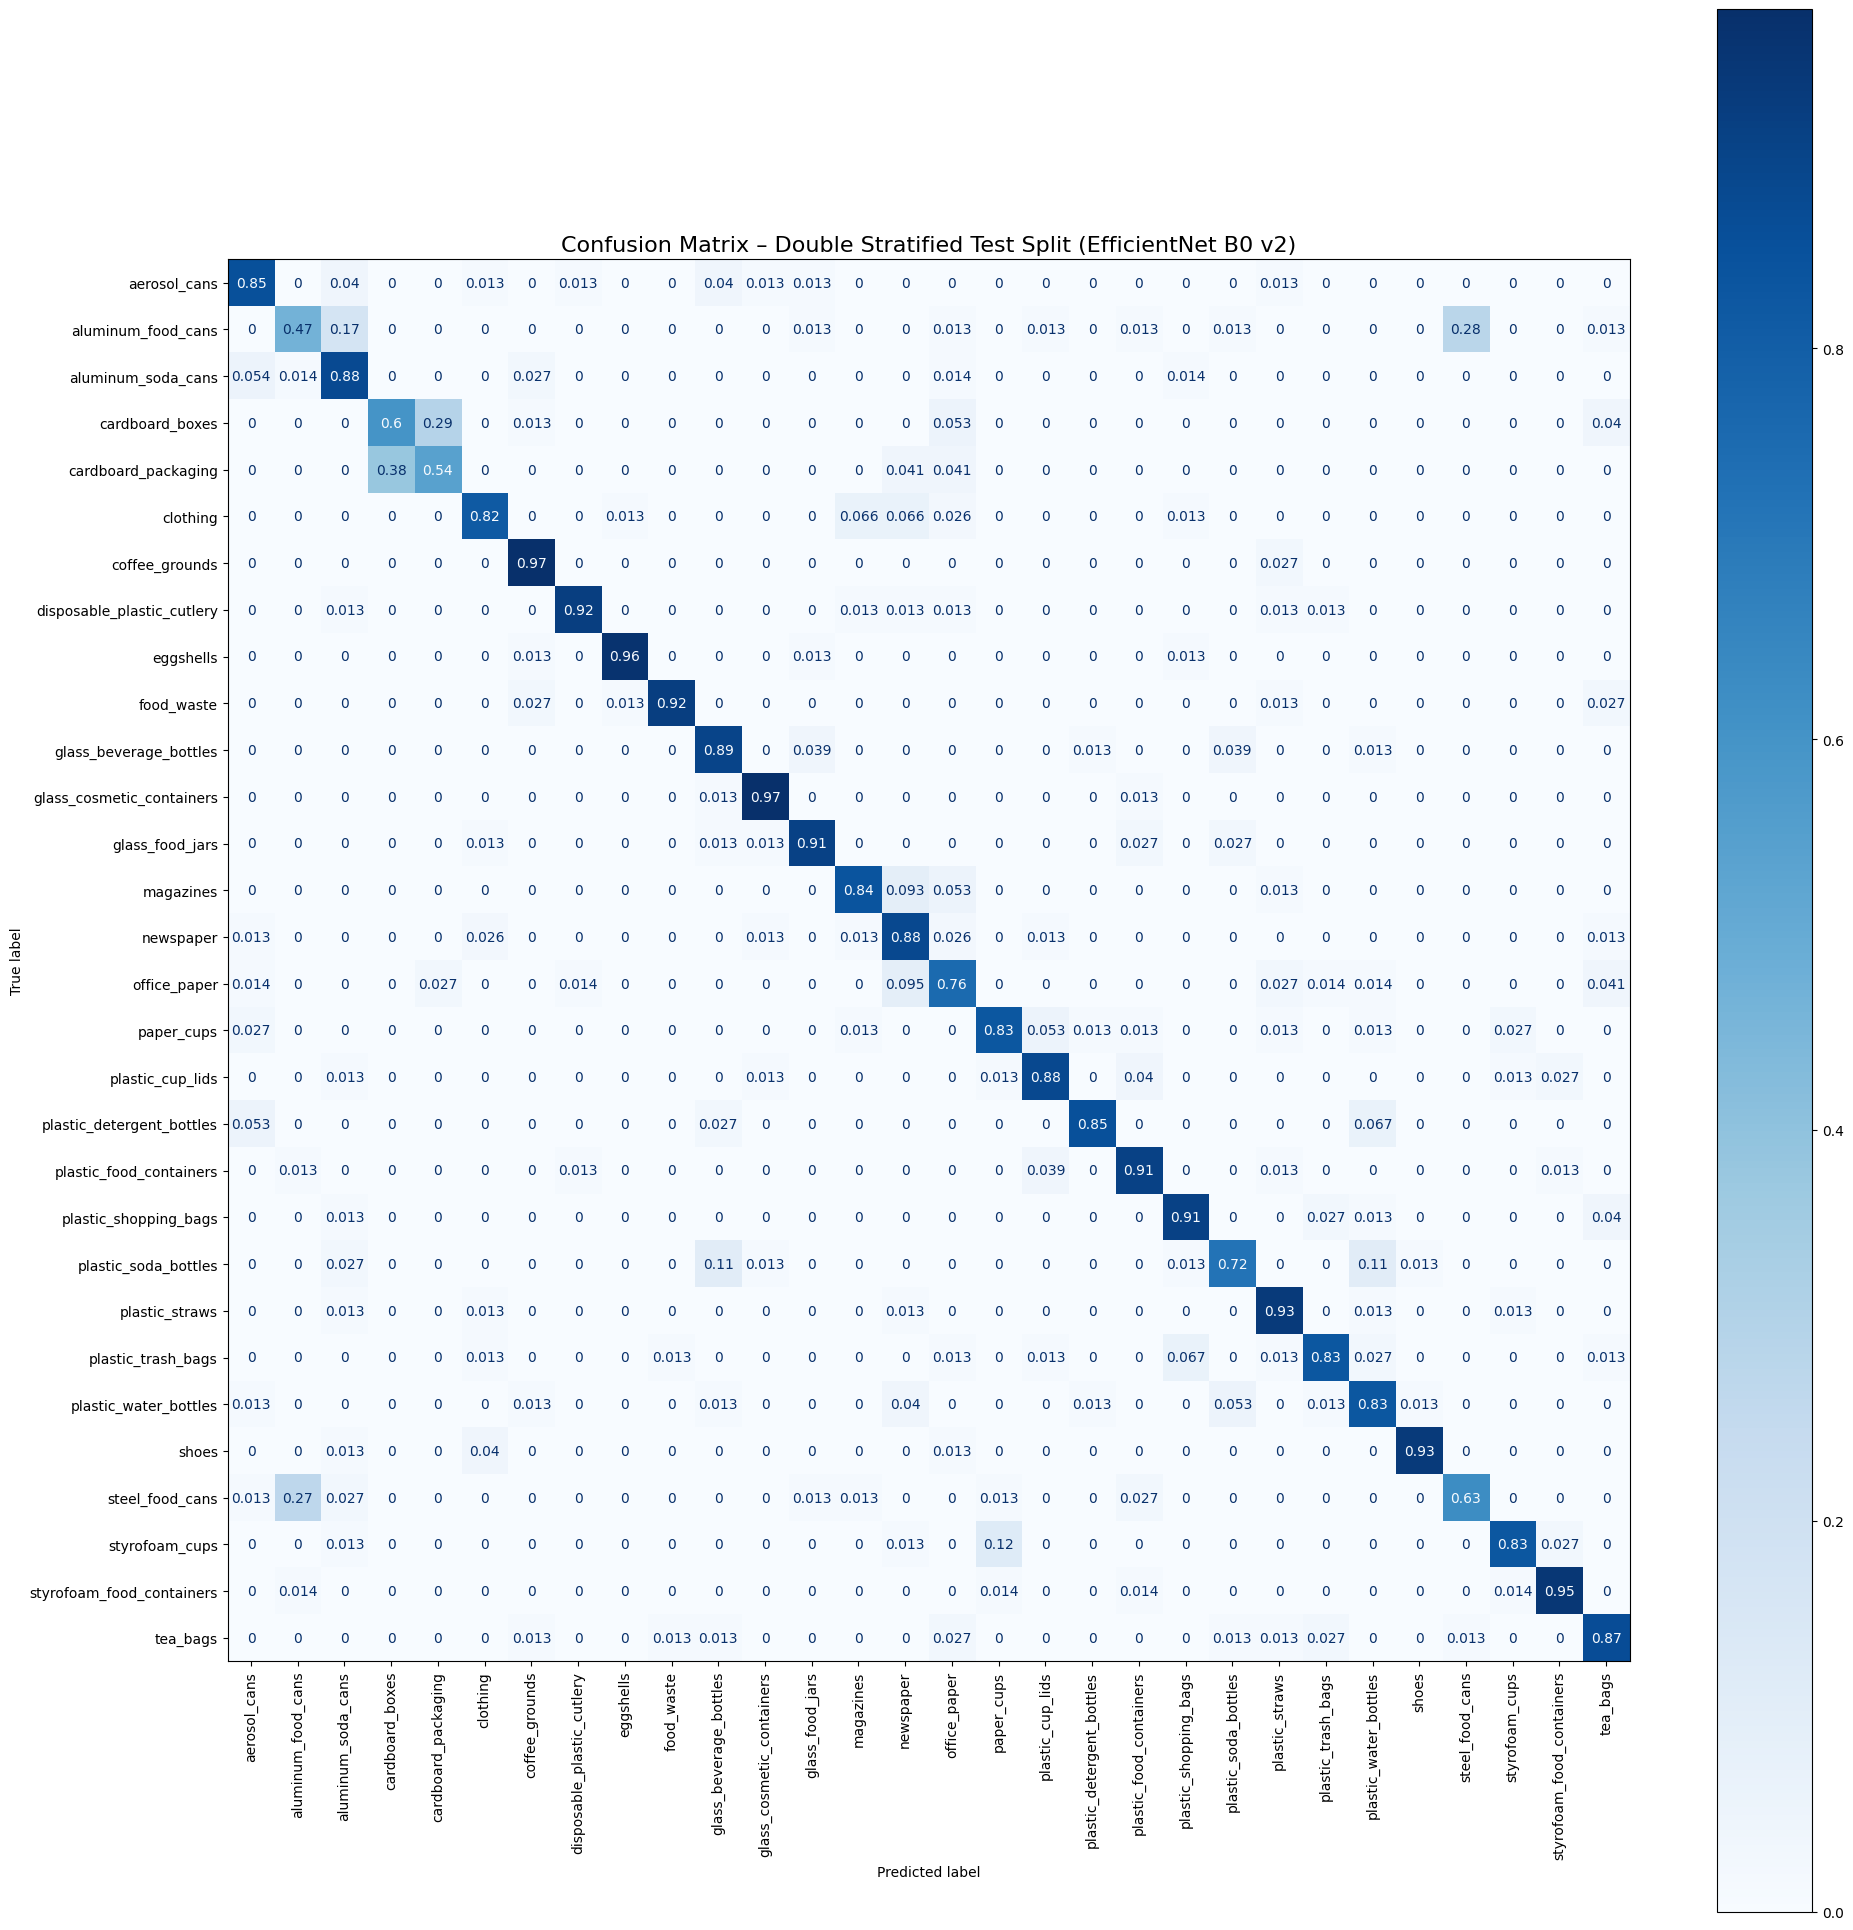

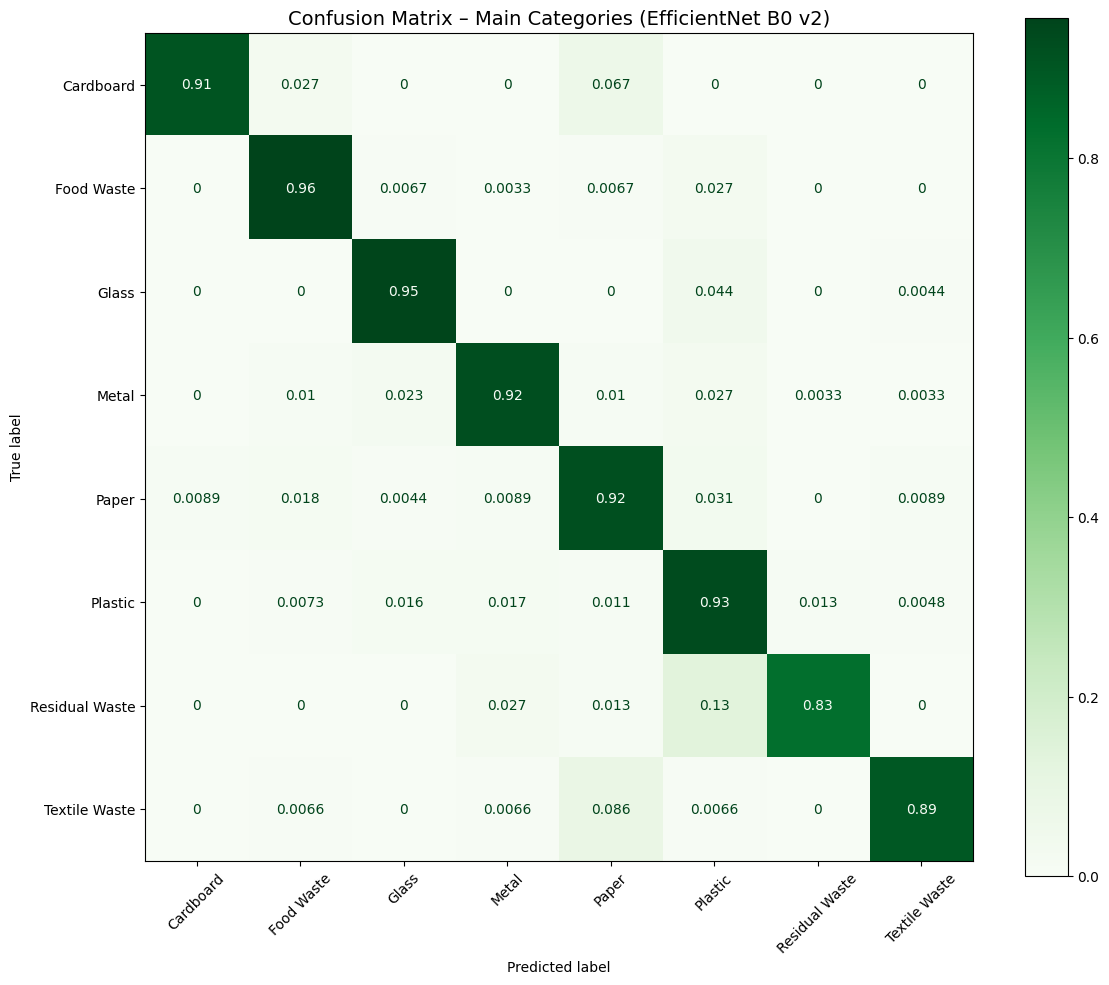


🔍 Per-Class Accuracy Breakdown (EfficientNet B0 v2):
---------------------------------------------
aerosol_cans                   — Accuracy: 85.33%
aluminum_food_cans             — Accuracy: 46.67%
aluminum_soda_cans             — Accuracy: 87.84%
cardboard_boxes                — Accuracy: 60.00%
cardboard_packaging            — Accuracy: 54.05%
clothing                       — Accuracy: 81.58%
coffee_grounds                 — Accuracy: 97.30%
disposable_plastic_cutlery     — Accuracy: 92.00%
eggshells                      — Accuracy: 96.00%
food_waste                     — Accuracy: 92.00%
glass_beverage_bottles         — Accuracy: 89.47%
glass_cosmetic_containers      — Accuracy: 97.37%
glass_food_jars                — Accuracy: 90.67%
magazines                      — Accuracy: 84.00%
newspaper                      — Accuracy: 88.16%
office_paper                   — Accuracy: 75.68%
paper_cups                     — Accuracy: 82.67%
plastic_cup_lids               — Accuracy: 88.00%


In [23]:
from torchvision import models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ----------------------
# TRANSFORMS (Optimized)
# ----------------------
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomApply([transforms.ColorJitter(0.2, 0.2, 0.2, 0.1)], p=0.5),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05)),  # 🔄 Simplified affine
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ----------------------
# DATASETS + LOADERS
# ----------------------
full_dataset_train = ImageFolder("images/", transform=transform_train)
full_dataset_val = ImageFolder("images/", transform=transform_val)

train_loader = DataLoader(torch.utils.data.Subset(full_dataset_train, double_strat_train_dataset.indices), batch_size=32, shuffle=True)
val_loader = DataLoader(torch.utils.data.Subset(full_dataset_val, double_strat_val_dataset.indices), batch_size=32, shuffle=False)
test_loader = DataLoader(torch.utils.data.Subset(full_dataset_val, double_strat_test_dataset.indices), batch_size=32, shuffle=False)
test_paths = [full_dataset_val.samples[i][0] for i in double_strat_test_dataset.indices]

# ----------------------
# Load EfficientNet B0 v2 Architecture
# ----------------------
model_b0v2 = models.efficientnet_b0(pretrained=True)
for param in model_b0v2.parameters():
    param.requires_grad = True  # ✅ Fine-tuned version

# ✅ Reconstruct the same classifier head used in training
model_b0v2.classifier[1] = nn.Sequential(
    nn.Linear(model_b0v2.classifier[1].in_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, num_classes)
)
model_b0v2 = model_b0v2.to(device)

# ✅ Load the trained weights
model_b0v2.load_state_dict(torch.load("best_efficientnet_model_v2.pt"))
model_b0v2.eval()

# ----------------------
# Initialize Tracking
# ----------------------
b0v2_class_correct = [0] * num_classes
b0v2_class_total = [0] * num_classes
b0v2_default_correct = b0v2_real_correct = 0
b0v2_default_total = b0v2_real_total = 0
b0v2_all_preds = []
b0v2_all_labels = []

# Mapping class index to category name
idx_to_class = {i: name for i, name in enumerate(full_dataset_val.classes)}
idx_to_main_category = {
    i: subcategory_to_main_category[name]
    for i, name in idx_to_class.items()
}

b0v2_adj_correct = 0
b0v2_adj_total = 0
b0v2_all_preds_main = []
b0v2_all_labels_main = []

# ----------------------
# Evaluation Loop
# ----------------------
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model_b0v2(images)
        _, predicted = torch.max(outputs, 1)

        for j in range(len(labels)):
            true_label = labels[j].item()
            pred_label = predicted[j].item()

            # Per-class accuracy
            b0v2_class_total[true_label] += 1
            if true_label == pred_label:
                b0v2_class_correct[true_label] += 1

            # Type-based accuracy
            img_index = i * test_loader.batch_size + j
            path = test_paths[img_index]
            if "default" in path:
                b0v2_default_total += 1
                if true_label == pred_label:
                    b0v2_default_correct += 1
            elif "real_world" in path:
                b0v2_real_total += 1
                if true_label == pred_label:
                    b0v2_real_correct += 1

            # Adjusted Accuracy
            true_main = idx_to_main_category[true_label]
            pred_main = idx_to_main_category[pred_label]
            if true_main == pred_main:
                b0v2_adj_correct += 1
            b0v2_adj_total += 1

            # For confusion matrix
            b0v2_all_preds.append(pred_label)
            b0v2_all_labels.append(true_label)
            b0v2_all_preds_main.append(pred_main)
            b0v2_all_labels_main.append(true_main)

# ----------------------
# Confusion Matrix (Subclass)
# ----------------------
cm_b0v2 = confusion_matrix(b0v2_all_labels, b0v2_all_preds, normalize="true")
disp_b0v2 = ConfusionMatrixDisplay(confusion_matrix=cm_b0v2, display_labels=full_dataset_val.classes)

fig, ax = plt.subplots(figsize=(20, 20))
disp_b0v2.plot(ax=ax, xticks_rotation=90, cmap="Blues", colorbar=True)
ax.set_xticklabels(full_dataset_val.classes, fontsize=10, rotation=90)
ax.set_yticklabels(full_dataset_val.classes, fontsize=10)
plt.title("Confusion Matrix – Double Stratified Test Split (EfficientNet B0 v2)", fontsize=16)
plt.tight_layout()
plt.show()

# ----------------------
# Confusion Matrix (Main Categories)
# ----------------------
main_categories = sorted(set(b0v2_all_labels_main + b0v2_all_preds_main))
cm_b0v2_main = confusion_matrix(b0v2_all_labels_main, b0v2_all_preds_main, labels=main_categories, normalize="true")
disp_b0v2_main = ConfusionMatrixDisplay(confusion_matrix=cm_b0v2_main, display_labels=main_categories)

fig, ax = plt.subplots(figsize=(12, 10))
disp_b0v2_main.plot(ax=ax, cmap="Greens", xticks_rotation=45)
plt.title("Confusion Matrix – Main Categories (EfficientNet B0 v2)", fontsize=14)
plt.tight_layout()
plt.show()

# ----------------------
# Accuracy Reporting
# ----------------------
print("\n🔍 Per-Class Accuracy Breakdown (EfficientNet B0 v2):\n" + "-" * 45)
for i, class_name in enumerate(full_dataset_val.classes):
    acc = 100 * b0v2_class_correct[i] / b0v2_class_total[i] if b0v2_class_total[i] > 0 else 0.0
    print(f"{class_name:30s} — Accuracy: {acc:.2f}%")

b0v2_default_acc = 100 * b0v2_default_correct / b0v2_default_total if b0v2_default_total > 0 else 0.0
b0v2_real_acc = 100 * b0v2_real_correct / b0v2_real_total if b0v2_real_total > 0 else 0.0

print("\n📸 Accuracy by Photo Type (EfficientNet B0 v2):\n" + "-" * 45)
print(f"Default Photos      — Accuracy: {b0v2_default_acc:.2f}% ")
print(f"Real-World Photos   — Accuracy: {b0v2_real_acc:.2f}% ")

b0v2_overall_acc = 100 * sum(b0v2_class_correct) / sum(b0v2_class_total)
print(f"\n✅ Overall Accuracy (EfficientNet B0 v2): {b0v2_overall_acc:.2f}%")

b0v2_adj_accuracy = 100 * b0v2_adj_correct / b0v2_adj_total
print(f"🎯 Adjusted Accuracy (Grouped by Main Categories): {b0v2_adj_accuracy:.2f}%")

# ADDITIONAL CHART FOR MEDIUM TO SHOW ADJ ACCURACY

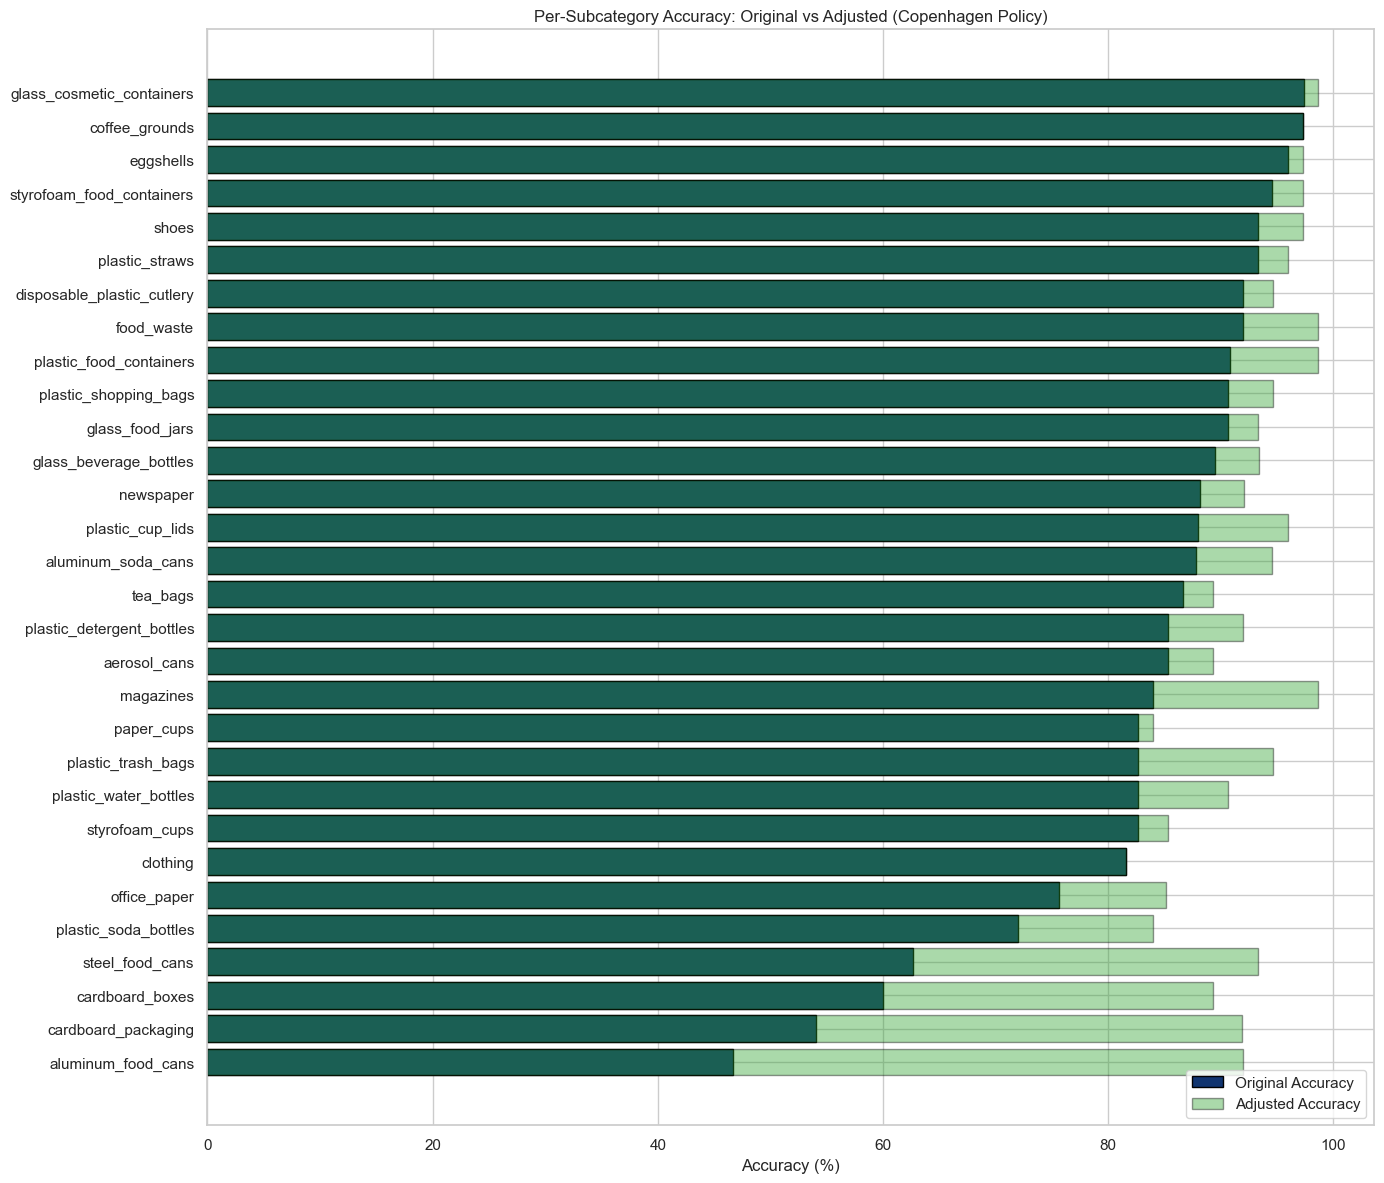

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize per-subcategory accuracy data
subcategory_data = {
    "subcategory": [],
    "main_category": [],
    "original_accuracy": [],
    "adjusted_accuracy": [],
}

# Build original and adjusted per-subcategory accuracy
for i, class_name in enumerate(full_dataset_val.classes):
    subcategory_data["subcategory"].append(class_name)
    main_cat = subcategory_to_main_category[class_name]
    subcategory_data["main_category"].append(main_cat)

    total = b0v2_class_total[i]
    correct = b0v2_class_correct[i]
    orig_acc = 100 * correct / total if total > 0 else 0.0
    subcategory_data["original_accuracy"].append(orig_acc)

    # Adjusted accuracy per instance
    adjusted_correct = 0
    for true_label, pred_label in zip(b0v2_all_labels, b0v2_all_preds):
        if true_label == i:
            pred_class_name = idx_to_class[pred_label]
            pred_main = subcategory_to_main_category.get(pred_class_name)
            if main_cat == "Residual Waste" and pred_main == "Paper" and class_name == "paper_cups":
                adjusted_correct += 1
            elif pred_main == main_cat:
                adjusted_correct += 1
    adj_acc = 100 * adjusted_correct / total if total > 0 else 0.0
    subcategory_data["adjusted_accuracy"].append(adj_acc)

# Convert to DataFrame
df = pd.DataFrame(subcategory_data)
df_sorted = df.sort_values(by="original_accuracy", ascending=True)

# Plotting
plt.figure(figsize=(14, 12))
sns.set(style="whitegrid")

# Use two distinct colors
original_color = "#113570"  # blue
adjusted_color = "#2ca02c"  # green


plt.barh(
    df_sorted["subcategory"],
    df_sorted["original_accuracy"],
    color=original_color,
    alpha=1.0,
    edgecolor='black',
    label="Original Accuracy"
)

plt.barh(
    df_sorted["subcategory"],
    df_sorted["adjusted_accuracy"],
    color=adjusted_color,
    alpha=0.4,
    edgecolor='black',
    label="Adjusted Accuracy"
)

plt.xlabel("Accuracy (%)")
plt.title("Per-Subcategory Accuracy: Original vs Adjusted (Copenhagen Policy)")
plt.legend()
plt.tight_layout()
plt.show()
